<div align="center">

# **MICRO - 452 : Basics of Mobile robotics**
### **Project**

Group 12

**Paul Huot-Marchand** <br>
**Luca Seelbach**<br>
**Manuela Waible** <br>
 

**Date:** *Automn 2025*
</div>

# Video Demonstration of the project : 
<div align="center">
<video controls>
    <source src="Report_images/Project_Demo.mp4" type="video/mp4">
</video>
</div>

# **INTRODUCTION**
This is the project associated with the class "Basics of Mobile Robotics", in which the goal is to use and implement various algorithm and robitics techniques seen in class with a Thymio robot, more precisely global & local navigation, computer vision, sensor filtering and motion control.

## 1. Objectifs 
The goal of this project is to use the Thymio robot and a camera to : 
- Create a map of an environment 
- Detect the starting position and target position in the environemnt
- Calculate a global path
- Move the robot towards the target location while avoiding obstacles (permanent and movable) 
- Be insensitive to Kidnapping and camera obscuring 

## Work repartition : 
### Computer Vision :
Attributed to : <b>Paul </b>

### Filtering : 
Attributed to : <b>Manuela</b>
### Global Navigation : 
Attributed to : <b>Luca</b>

### Local Navigation : 
Attributed to : <b>Luca</b>

### Motion :  
Attributed to : <b>Manuela</b>
## 2. Environment : 
For the environment, we chose to have a large white paper sheet with black obstacles to be less sensitive to lighting condition. The only conditions we set on the obstacles were that they are not an isosceles triangle nor round since those shapes are reserved respectively for the robot and the end goal.  We also consider the borders of the sheet as obstacles so that the robot never exits the environment. Local obstacles are defined in various sizes and shapes, like square or round objects.
<div align="center">
<img src="Report_images/Environnement.png" style="transform: rotate(-90deg)" width=500px>
</div>


# Libraries

In [ ]:
!pip install tdmclient numpy scipy opencv-python tqdm

In [1]:
import numpy as np
from scipy.ndimage import distance_transform_edt
import cv2
import tqdm
from Computer_vision import cv as com
#import Filtering as flt 
from Global_Nav import global_nav as gb
import matplotlib.pyplot as plt

import math as m
import numpy as np
from collections import deque
from matplotlib.animation import FuncAnimation

from Filtering import Control_fromEKF as control
from Filtering import Filtering as filt
from Local_Nav import local_nav as ln



In [ ]:
# Initiate the communication between the Thymio and the computer
from tdmclient import ClientAsync, aw
client = ClientAsync()

node = await client.wait_for_node()
await node.lock() 

## Computer Vision 
This section is fully implemented in the `Computer_vision/cv.py` file.
## 1. Vision Pipeline Overview

The vision pipeline is divided into three main stages:

1. **Frame acquisition & environment detection**  
   Capture the global frame, detect the environment, and perform perspective correction.

2. **Obstacle and goal detection**  
   Detect obstacles and the goal on the transformed image to generate an occupancy map.

3. **Robot detection**  
   Identify the robot and compute its orientation.

---

## 2. Image Filtering Pipeline

At each stage, the following filtering operations are applied:

- **Grayscale conversion**  
  Simplifies detection since obstacles are black and the environment is white.

- **Bilateral filtering**  
  Removes noise while keeping edges sharp. Must be tuned carefully to avoid weakening obstacle contours due to shadows.

- **Canny edge detection**  
  Produces a binary edge image The treshold of the canny edge filter is "auto-tuned" according to the image using

  `median_val = np.median(gray)
    lower = int(max(0, c1 * median_val))
    upper = int(min(255, c2 * median_val))`

  which is a common heuristic to tune gradient threshold [1].

  If an image is globally bright (high `median_val`) the intensity value vary over a larger dynamic range and gradient tends to be stronger everywhere.

- **Morphological closing - Dilation - Morphological closing**  
  Make Canny edges thicker, smoother, and more connected so that later steps (contour detection) work better.

  Morphological closing consist in dilatation followed by erosion to suppress cracks and small holes.

  Dilatation :  if one pixel is foreground under the kernel the pixel become foreground

  Erosion : if all pixel are foreground under the kernel the pixel become foreground, else the pixel become background

  We added a step of dilatation between the two morphological closing to increase the closing capacity. The extra dilation increases the ability to connect contours,
  especially when the gaps are larger than what one closing can handle.
 
The filtering parameters must be retuned when the environment or lighting conditions changes significantly, especially for environment detection. Is the ground is light our method can struggle to identify the sheet. 

We use different filtering parameters for the different applications because the perspective correction can induce significant noise so we need to be more aggressive in filtering.

[1] A. Rosebrock, “Zero-parameter, automatic Canny edge detection with Python and OpenCV,” PyImageSearch, 2015.  

In [ ]:
def filter_image(image, b1, b2, b3, c1, c2, m1, cl1, m, d, env = False, dil = True) :
    """
    INPUT : IMAGE AND FILTER PARAMETERS
    OUTPUT : IMAGE FILTERED
    Apply successive filters to a given image
    """
    if env :
        image= contour_fixing(image)
        
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Bilateral filter
    filtered_img = cv2.bilateralFilter(gray, b1, b2, b3)

    # Canny edges
    median_val = np.median(gray)
    lower = int(max(0, c1 * median_val))
    upper = int(min(255, c2 * median_val))
    canny_img = cv2.Canny(filtered_img, lower, upper)

    if dil :
        # Morphological filter
        kernel1 = np.ones((m,m), np.uint8)
        kernel2 = np.ones((d,d), np.uint8)
        closed = cv2.morphologyEx(canny_img, cv2.MORPH_CLOSE, kernel1)
        
        closed = cv2.dilate(closed, kernel2, iterations=1)
        closed = cv2.morphologyEx(closed, cv2.MORPH_CLOSE, kernel1)

    
        if DEBUG1:
            titles = ["Grayscale", "Bilateral", "Canny", "Morphological + Dilatation"]
            images = [gray, filtered_img, canny_img, closed]
    
            plt.figure(figsize=(20, 10))
            for i, (img, title) in enumerate(zip(images, titles)):
                plt.subplot(1, 4, i+1)
                plt.imshow(img, cmap='gray')
                plt.title(title)
                plt.axis('off')
            plt.show()
        
        return closed
        
    else :
        return canny_img
        
DEBUG1 = True
filtered_image = filter_image(img, B1_O, B2_O , B3_O, C1_O, C2_O, M1_O, CL1_O, M_O, D_O, False)

<img src="Report_images/visionFirst.png" width=2000px>

In [ ]:
#=========GEOMETRICAL FUNCTIONS=========
def orderpoints(pts) :
    """
    Order points of a square counterclockwise
    """
    pts = pts[np.argsort(pts[:, 1]), :]  # Sort by y
    
    top = pts[:2]
    bottom = pts[2:]
    
    # Sort top-left and top-right by x
    if top[0, 0] < top[1, 0]:
        tl, tr = top[0], top[1]
    else:
        tl, tr = top[1], top[0]
        
    # Sort bottom-left and bottom-right by x
    if bottom[0, 0] < bottom[1, 0]:
        bl, br = bottom[0], bottom[1]
    else:
        bl, br = bottom[1], bottom[0]
    
    return np.array([tl, tr, br, bl], dtype="float32")

def find_square(contour, approx, area) :
    """
    Return the shape approximated by a square if the approximation stays in the limit of approx
    """
    
    cnt_len = cv2.arcLength(contour, True)
    cnt = cv2.approxPolyDP(contour, approx*cnt_len, True)

    if len(cnt) == 4 and cv2.contourArea(cnt) > area and cv2.isContourConvex(cnt):
        find = True
        return find, cnt.reshape(-1,2)
    else : 
        find = False
        return find, None


## 3. Contour Detection

The filtered binary image is passed to `cv2.findContours`, which uses the Suzuki85 algorithm to detect boundaries.

### 3.1 `cv2.findContours`

A contour is a curve connecting continuous boundary points of equal intensity.  
From a binary image, the function extracts these boundaries.

**Output**

- `contours` — list of contours (each contour is an array of `(x, y)` points)  
- `hierarchy` — optional structure describing parent/child relations

### 3.2 Contour Approximation: `cv2.CHAIN_APPROX_SIMPLE`

- Compresses horizontal, vertical, and diagonal segments  
- Keeps only segment endpoints  
- Reduces memory usage without losing important shape information
This parameter was used since we will approximate the detected shapes later so we don't care about having 100% precise contours.

### 3.3 Contour detection Algorithm (Suzuki85)

1. **Image scanning**  
   The image is scanned left to right, row by row.

2. **Contour start detection**  
   A pixel is a contour start if it is foreground(white) and has a background neighbor(black).
    - The algorithm then follow the contour using  8-connectivity (if an other foreground pixel is here its the next point of the contour)
    - Label each contour pixel as already part of a contour
    - Stop when we reach the starting point again


### 3.4 Practical Use

- The hierarchy is not used in our pipeline.  
- We use `CHAIN_APPROX_SIMPLE` that already provides simplified but accurate contours by only keeping start and end points of straight lines

---


## 4 Environment (Rectangle)

Among all four-sided polygons, the largest quadrilateral is selected as the environment.


### 4.1 Perspective Correction

Perspective correction compensates for camera tilt or misalignment.

#### Steps

1. Detect the environment rectangle in the initial frame.  
2. Reorder its corners counterclockwise (required for next step)
3. Compute the homography matrix for perspective correction using `matrix = cv2.getPerspectiveTransform(pts1, pts2)` : 

**Homography Matrix Format:**
\begin{bmatrix}
h_0 & h_1 & h_2 \\
h_3 & h_4 & h_5 \\
h_6 & h_7 & 1
\end{bmatrix}

**Mathematical Foundation:**  
Given point \((x, y)\) in `pts1` the mapping equation to \((X, Y)\) in `pts2` is given by:


$x h_0 + y h_1 + h_2 = X (x h_6 + y h_7 + 1)$


$x h_3 + y h_4 + h_5 = Y (x h_6 + y h_7 + 1)$


**Solving Process:**

We have 4 corners leading to 4 points pair which give 8 linear equations.
This can be formulated as a system $A \mathbf{h} = \mathbf{b}$ (8×8 matrix)
solved by OpenCV using Gaussian elimination.

In the end the goal is to have `pts2_point = matrix @ pts1_point`

4. Apply the homography matrix using `warped = cv2.warpPerspective(image, matrix, (SIZE[0], SIZE[1]))` :

For every pixel $(x, y)$ in the image we do :

`xs, ys, w = inv(matrix) @ [x, y, 1]`  

$(xs/w,ys/w)$ being the pixel coordinates on the source image and $w$ the scaling factor.
Since $(xs/w,xs/w)$ can not end on a pixel center we need to interpolate to know the value of the pixel.
This is done using neighborhood lookup: The algorithm looks at source pixels around (xs, ys) and computes the output value from them using an interpolation rule.
We used the default interpolation method `cv2.INTER_LINEAR` which blends the 2×2 neighborhood around (xs, ys) with weights proportional to the distances. It is a good balance of speed and smoothness while having some default for warping and resizing.

This is done pixel-by-pixel to fill the output image. 

**Result:** Stable top-down "bird's eye" view of the environment



In [ ]:
def matrix_perspective(image) :
    """
    Detect the sheet, return the matrix of perspective correction
    """

    filtered_image = filter_image(image, B1_O, B2_O , B3_O, C1_O, C2_O, M1_O, CL1_O, M_O, D_O, False)
    
    contours, hierarchy = cv2.findContours(filtered_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if DEBUG2 :
        plt.figure()
        image_contours_plot = image.copy()
        cv2.drawContours(image_contours_plot, contours, -1, (0, 255, 0), 2)
        
    
    if DEBUG2 : image_plot = image.copy()
        
    squares = []
    for cnt in contours:
        find = False
        find, square = find_square(cnt, Env_approx, Min_area_env)
        if find :
            squares.append(square)
            if DEBUG2 :
                cv2.drawContours(image_plot, [square], -1, (255, 0, 0), 2)

    

    area = 0
    sheet = None
    for square in squares:
        if cv2.contourArea(square) > area :
            sheet = square
            area = cv2.contourArea(square)
    
    if sheet is not None:
        sheet_ordered = orderpoints(sheet)
        tl, tr, br, bl = [tuple(pt.astype(int)) for pt in sheet_ordered]
    else : print("ERROR : SHEET is EMPTY")
    
    pts1 = sheet_ordered
    pts2 = np.array([[0, 0], [SIZE[1]-1, 0], [SIZE[1]-1, SIZE[0]-1], [0, SIZE[0]-1]],dtype=np.float32)
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    
    #DISPLAY
    if DEBUG2:
        titles = ["Detected contour", "Detected environment"]
        images = [image_contours_plot, image_plot]
    
        plt.figure(figsize=(40, 20))
        for i, (img, title) in enumerate(zip(images, titles)):
            plt.subplot(1, 4, i+1)
            plt.imshow(img, cmap='gray')
            plt.title(title)
            plt.axis('off')
        plt.show()
        
    print("Homography matrix (2 decimals):")

    for row in matrix:
        print("[", "  ".join(f"{val:.2f}" for val in row), "]")
    return matrix


def convert_perspective(image,matrix) : 
    """
    apply the perspective corrextion
    """
    transformed_image = cv2.warpPerspective(image,matrix,(SIZE[1],SIZE[0]))
    return transformed_image

#COMPUTE THE TRANSFORMATION TO CORRECT PERSPECTIVE
DEBUG1 = False
DEBUG2 = True
matrix = matrix_perspective(img)
#CORRECT THE PERSPECTIVE
transformed_image = convert_perspective(img,matrix)
#PLOTTING
plt.figure()
plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
plt.title("PERSCPECTIVE CORRECTED IMAGE")
plt.axis('off')
plt.show()


<img src="Report_images/visionFound.png" width=700px>
<img src="Report_images/visionCorrected.png" width=500px>

In [ ]:
#=========GEOMETRICAL FUNCTIONS=========
def find_triangle(contour, approx, area_min, area_max, image = None) :
    """
    Return the shape approximated by a triangle if the approximation stays in the limit of approx
    """
    
    cnt_len = cv2.arcLength(contour, True)
    cnt = cv2.approxPolyDP(contour, approx*cnt_len, True)
    
    elem = []
    if len(cnt) == 3 and cv2.contourArea(cnt) > area_min and cv2.contourArea(cnt) < area_max:
        cnt = cnt.reshape(-1, 2)
        elem = cnt
        find = True
        return find, elem
    else : 
        find = False
        return find, elem
    
def altitude_line(TOP, B, C):
    """
    Returns the parametric line of the altitude from base B-C to the TOP vertex.
    """
    Tx, Ty = TOP
    Bx, By = B
    Cx, Cy = C

    # base vector
    ux = Cx - Bx
    uy = Cy - By

    # vector from B to TOP
    wx = Tx - Bx
    wy = Ty - By

    #scalar  projection  to get foot of altitude
    u_dot_u = ux*ux + uy*uy
    t = (wx*ux + wy*uy) / u_dot_u

    # foot of altitude (on base)
    Px = Bx + t*ux
    Py = By + t*uy

    # direction vector from base to TOP
    vx = Tx - Px
    vy = Ty - Py

    return (Px, Py), (vx, vy)

def order_triangle(P1,P2,P3) :
    """
    Return the corner of the triangle ordered (TOP, LEFT, RIGHT)
    and a confidence indice on how much the triangle is isoscele
    """
    dist_A = math.dist(P1, P2)
    dist_B = math.dist(P2, P3)
    dist_C = math.dist(P3, P1)
    
    diff_A_B = abs(dist_A-dist_B)
    diff_B_C = abs(dist_B-dist_C)
    diff_C_A = abs(dist_C-dist_A)
    
    if diff_A_B < diff_B_C and diff_A_B < diff_C_A :
        TOP = P2
        LEFT = P1
        RIGHT = P3
        confidence = diff_A_B/dist_B
    elif diff_B_C < diff_A_B and diff_B_C < diff_C_A :
        TOP = P3
        LEFT = P2
        RIGHT = P1
        confidence = diff_B_C/dist_C
    elif diff_C_A < diff_A_B and diff_C_A < diff_B_C :
        TOP = P1
        LEFT = P3
        RIGHT = P2
        confidence = diff_C_A/dist_A
    else :
        print("no summit found, adjust threshold")

    ordered = [TOP,LEFT, RIGHT]
    return ordered, confidence

def contour_fixing(image) :
    """
    Fill the border of the image with white pixels to avoid detecting strange contour
    """
    h, w = image.shape[:2]

    # border width
    b = 10

    image[:b, :] = (255, 255, 255)

    image[h-b:h, :] = (255, 255, 255)

    image[:, :b] = (255, 255, 255)

    image[:, w-b:w] = (255, 255, 255)
    return image



## 5 Robot (Triangle)

The robot is identified as the triangle with the highest score from the `order_triangle` function,  
which measures how close the polygon is to an isosceles triangle. We compute the minimum difference in length between two segment of the triangle scaled by the length of the side. The smaller this difference the closer we are to an isoscele triangle.

### 5.1 Robot Orientation

The robot’s orientation is computed using triangle geometry:
Once we detected the triangle, `order_triangle` gives back the corners of the triangle ordered as shown on the picture below. 


<img src="Report_images/triangle.jpg" alt="Schéma" width="400">

Knowing the "order" of the corners of the triangle we can then compute the equation of the altitude line and derive the orientation vector from the base to the top corner from these points.


In [ ]:
def get_robot(image):
    
    filtered_image = filter_image(image, B1_T, B2_T , B3_T, C1_T, C2_T, M1_T, CL1_T, M_T, D_T, True, True)
    
    contours, hierarchy = cv2.findContours(filtered_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if DEBUG4 :
        plt.figure()
        image_contours_plot = image.copy()
        cv2.drawContours(image_contours_plot, contours, -1, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(image_contours_plot, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Detected Contours")
        plt.show()
     
        image_contours = transformed_image.copy()
    
    triangle =[]
    find_t = False
    confidence = 10
    for cnt in contours:
        find_t, tri= find_triangle(cnt, Rob_approx, Min_area_rob, Max_area_rob, image)
        if find_t :
            _, conf = order_triangle(tri[0], tri[1], tri[2])
            if conf < confidence :
                triangle = tri
                confidence = conf
                if DEBUG4 :
                    cv2.drawContours(image_contours, [triangle], -1, (255, 0, 0), 2)

    pos = []
    angle = 0
    if triangle is not None and len(triangle) != 0:
        if DEBUG4 :
            cv2.drawContours(image_contours, [triangle], -1, (255, 255, 0), 2)
            plt.figure()
            plt.imshow(cv2.cvtColor(image_contours, cv2.COLOR_BGR2RGB))
            plt.title("Detected Triangles, the robot one is in light blue")
            plt.axis('off')
            plt.show()
            
        tri_ordered,_ = order_triangle(triangle[0], triangle[1], triangle[2])
        alt = altitude_line(tri_ordered[0], tri_ordered[1], tri_ordered[2] )
        pos = alt[0]
        angle = np.atan2(alt[1][1],alt[1][0])
        print("ROBOT FOUND")
        Rob = True
    else :
        print("NO ROBOT FOUND")
        Rob = False



    if DEBUG4:
        titles = ["Detected contour", "Detected Triangles, the robot one is in light blue"]
        images = [image_contours_plot, image_contours]
    
        plt.figure(figsize=(40, 20))
        for i, (img, title) in enumerate(zip(images, titles)):
            plt.subplot(1, 4, i+1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            #plt.imshow(img, cmap='gray')
            plt.title(title)
            plt.axis('off')
        plt.show()
        
    return pos, angle, Rob


DEBUG4 = True
robot = get_robot(transformed_image)

x, y = robot[0]
theta = robot[1]

print(f"Robot position: ({x:.2f}, {y:.2f})")
print(f"Robot angle: {theta:.2f} rad")

#PLOTTING
global_map4plot = transformed_image.copy()
if robot[2] :
    length = 80
    end_x = int(robot[0][0] + length * np.cos(robot[1]))
    end_y = int(robot[0][1] + length * np.sin(robot[1]))
    end_point = (end_x, end_y)
    
    robot1 = [int(robot[0][0]),int(robot[0][1])]
    cv2.arrowedLine(global_map4plot, robot1, end_point, color=(255, 2, 2), thickness=5)


plt.imshow(global_map4plot)
plt.title("Robot Orientation")
plt.axis('off')
plt.show()



<img src="Report_images/visionAllForms.png" width=900px>
<img src="Report_images/visionRobotOrient.png" width=450px>

In [ ]:
#=========GEOMETRICAL FUNCTIONS=========
def find_shape(contour, approx, area_min, area_max = 10000) :
    """
    Return the shape approximated according to approx if the area is whithin the treshold
    """
    
    cnt_len = cv2.arcLength(contour, True)
    cnt = cv2.approxPolyDP(contour, approx*cnt_len, True)
    
    if cv2.contourArea(cnt) > area_min and cv2.contourArea(cnt) < area_max  :
        find = True
        return find, cnt.reshape(-1,2)
    else : 
        find = False
        return find, None
    


def find_circle(contour, min_area, max_area) :
    """
    Return the shape approximated by a circle and its circularity if the shape is whithin the area adn circularity threshold
    """
    (x, y), radius = cv2.minEnclosingCircle(contour)

    area_contour = cv2.contourArea(contour)
    area_circle = np.pi * radius * radius
    find = False
    circularity = area_contour / area_circle
    circle = []
    
    if 0.5 < circularity < 1.9 and (area_circle > min_area and area_circle < max_area):
        
        center = (int(x), int(y))
        radius = int(radius)
        circle = [center,radius]
        find = True
        return find, circle, circularity
    
    return find, circle, circularity

        
def get_inter_shape(shapes):
    """
    Fill the occupancy map with the interior of the shapes with -1
    """
    occupancy = np.zeros((SIZE[0], SIZE[1]))
    for shape in shapes:
        cv2.drawContours(occupancy, [shape], -1, OCCUPIED_SPACE, cv2.FILLED)
    return occupancy




def dist_point_to_segment(px, py, ax, ay, bx, by):
    """Distance from point P to segment AB."""
    A = np.array([ax, ay], dtype=float)
    B = np.array([bx, by], dtype=float)
    P = np.array([px, py], dtype=float)

    AB = B - A
    AP = P - A

    t = np.dot(AP, AB) / np.dot(AB, AB)
    t = np.clip(t, 0, 1)  # projection inside segment

    closest = A + t * AB
    return np.linalg.norm(P - closest)

def dist_point_to_polygon(px, py, polygon):
    """Polygon = list/array of (x,y)."""
    min_dist = float('inf')
    n = len(polygon)

    for i in range(n):
        x1, y1 = polygon[i]
        x2, y2 = polygon[(i+1) % n]
        d = dist_point_to_segment(px, py, x1, y1, x2, y2)
        if d < min_dist:
            min_dist = d

    return min_dist
    


## 5. Occupancy Map Construction

### 5.1 Goal (Circle)

For each contour we compute its minimum enclosing circle and the area ratio defined as:  

$\text{ratio} = \frac{\text{circle area}}{\text{contour area}}$

The most circular shape (lowest ratio) is selected as the goal.

### 5.2 Obstacles

Remaining shapes (neither robot nor goal) are classified as obstacles, using:

- Polygon approximation  
- Area thresholds

Additionally we use the function `contour_fixing` to fill with white pixels the border of the transformed image that can be imperfect after perspective correction to avoid detecting unwanted shaped there.

Note : Even after the contour fixing it can happen that we detect narrow shapes on the border but it does not represent any issue since we already don't want the robot to exit the sheet.

We generate an occupancy grid with the same dimensions as the processed image by filling the detected shapes :

A circular mask is applied to the goal : 

dist_mask = $(X - cx)^2 + (Y - cy)^2 <= radius^2$

`map_[dist_mask] = GOAL`

The obstacles are filled using `cv2.drawContours(occupancy, [shape], -1, OCCUPIED_SPACE, cv2.FILLED)`. 
This works by scanning the image row by row and finding where the shape edges cross the row. It then fill the row between the 2 intersections.

The following convention is used :
- `0` → free space  
- `-1` → obstacle  
- `-3` → goal  

A one-pixel border of `-1` surrounds the map to prevent the robot from leaving the environment.


## 6. Overlapping Management

Sometimes the goal is mistakenly classified as an obstacle.  
To fix this, obstacles whose vertices lie inside the goal area are removed from the obstacle set.

## 7. Motivation
Every step of our computer vision relies on contour detection which allowed us tu reuse functions and method between the different steps. Most of the shape choices where made so that we can use simple geometrical tools to process and identify the shape.

## 8. Remark and limitation
Occasionally, the robot triangle may not be detected correctly, but this occurs only in rare frames or specific robot positions. We consider this to be acceptable.

Our method appears to be quite robust to changes in lighting conditions, thanks to the strong contrast between the black shapes and the white environment and our choice to use only contour detection and not pixel values. This contrast allows us to apply aggressive filtering and remove a significant amount of noise.

However, the main limitation arises from the contrast between the floor and the white sheet: if the floor is not sufficiently distinguishable, environment detection can fail.


In [ ]:
def get_map(image) :

    filtered_image = filter_image(image, B1_C, B2_C , B3_C, C1_C, C2_C, M1_C, CL1_C, M_C, D_C, True)
   
    contours, hierarchy = cv2.findContours(filtered_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if DEBUG3 :
        plt.figure()
        image_contours_plot = image.copy()
        cv2.drawContours(image_contours_plot, contours, -1, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(image_contours_plot, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Detected contour")
        plt.show()  
        image_contours = transformed_image.copy()

    
    robot_pos,_, Rob = get_robot(image)

    shapes =[]
    find_s = False
    find_circ = False
    confidence = 100
    for cnt in contours:
        find_s, shape= find_shape(cnt, Obs_approx, Min_area_obs, Max_area_obs)
        find_c, circle_pot, confidence_pot = find_circle(cnt, Min_area_goal, Max_area_goal)
        if find_s :
            if dist_point_to_polygon(robot_pos[0], robot_pos[1], shape) > R_ROBOT_p :
                shapes.append(shape)
                if DEBUG3 : cv2.drawContours(image_contours, [shape], -1, (255, 0, 0), 2)
        if find_c:
            if Rob : 
                # compute distance between robot and circle
                cx, cy = circle_pot[0]
                rx, ry = robot_pos
                dist = np.hypot(cx - rx, cy - ry)
                # ignore circle if too close to robot
                if abs(confidence_pot - 1) < confidence and dist > R_ROBOT_p:
                    confidence = abs(confidence_pot - 1)
                    circle = circle_pot
                    find_circ = True
            else :
                if abs(confidence_pot - 1) < confidence :
                    confidence = abs(confidence_pot - 1)
                    circle = circle_pot
                    find_circ = True

    if find_circ:
        cx, cy = circle[0]
        r = circle[1]

        shapes = [
            sh for sh in shapes
            if dist_point_to_polygon(cx, cy, sh) > r+10
            ]

   
    if DEBUG3 :
        plt.figure()
        plt.imshow(cv2.cvtColor(image_contours, cv2.COLOR_BGR2RGB))
        plt.title("Detected shapes (blue)")
        plt.axis('off')
        plt.show()
    
    map_ = get_inter_shape(shapes)

    
    if find_circ :
        if DEBUG3 :
            cv2.circle(image_contours, circle[0], circle[1], (0, 255, 0), -1)
            
        (cx, cy) = circle[0]
        radius = circle[1]
        # Dimensions
        h, w = map_.shape
    
        # Grille de coordonnées
        Y, X = np.ogrid[:h, :w]
    
        # Condition du disque (distance <= rayon)
        dist_mask = (X - cx)**2 + (Y - cy)**2 <= radius**2
    
        # Application
        map_[dist_mask] = GOAL
    
        
        map_[cy,cx] = GOAL
        
    if DEBUG3 :    
        plt.imshow(map_, cmap='gray')
        plt.title("Occupancy map (blue)")
        plt.axis('off')
        plt.show()

    print("MAP ANALYZED : ")
    if find_circ:
       print("GOAL FOUND")
    else:
        print("NO GOAL DETECTED")
       
    return map_
DEBUG3 = True
DEBUG4 = False
global_map = get_map(transformed_image)

<img src="Report_images/v1.png" width="500">
<img src="Report_images/v2.png" width="500">
<img src="Report_images/v3.png" width="500">

## Constants

In [ ]:
"""
# are also under vision

def length_real_to_pixel(length_cm, env_size_cm, map_size):
    
    L, W = env_size_cm
    height, width = map_size
    
    # scale factors
    scale_x = width / L
    scale_y = height / W
    
    # average scale for uniform scaling
    scale = (scale_x + scale_y) / 2
    
    return length_cm * scale

#================HYPERPARAMETESRS======================
## COMPUTER VISION ## 

#SiZE OF THE ENVIRONEMENT (cm)
L = 113.5
W = 81.3
Ratio = L/W

#SiZE IN PIXEL OF THE CORRECTED MAP
Y_res = 480
SIZE = [Y_res, int(Y_res*Ratio)]

#SIZE OF THE TRIANGLE (cm)
L_T = 10
H_T = 3.5
L_T_p = length_real_to_pixel(L_T,[L,W], SIZE)
H_T_p = length_real_to_pixel(H_T,[L,W], SIZE)

#SIZE OF THE GOAL (cm)
R_G = 8.4/2

R_G_p = length_real_to_pixel(R_G,[L,W], SIZE)

# AREA RATIO
RATIO_T = (L_T*H_T/2) / (L*W) 

#FILTERING PARAMETERS FOR THE ORIGINAL IMAGE
B1_O = 5
B2_O = 50
B3_O = 50
C1_O = 0.5
C2_O = 1.5
M1_O = 8
CL1_O = 2.0
M_O = 5
D_O = 5

#FILTERING PARAMETERS FOR THE CORRECTED IMAGE
B1_C = 8
B2_C = 70
B3_C = 70
C1_C = 0.4
C2_C = 1.6
M1_C = 5
CL1_C = 4.0
M_C = 5
D_C = 5

#FILTERING PARAMETERS FOR ROBOT DETECTION
B1_T = 5
B2_T = 80
B3_T = 80
C1_T = 0.4
C2_T = 1.6
M1_T = 5
CL1_T = 2
M_T = 2
D_T = 2


#PARAMETERS TO DETECT THE ENV
#Min_area_env = 1920*1080*0.01   #Min area in pixel of the env
Min_area_env = 1000
Env_approx = 0.1

#PARAMETERS TO DETECT THE OBSTACLES
Min_area_obs = SIZE[0]*SIZE[1]*0.005   #Min area in pixel of the env
Max_area_obs = SIZE[0]*SIZE[1]*0.5   #Max area in pixel of the env
Obs_approx = 0.01

#PARAMETERS TO DETECT GOAL
Min_area_goal = np.pi * R_G_p * R_G_p *0.8
Max_area_goal = np.pi * R_G_p * R_G_p * 1.8

#PARAMETERS TO DETECT THE ROBOT
Min_area_rob = (L_T_p*H_T_p /2) * 0.2   #Min area in pixel of the env
Max_area_rob =  (L_T_p*H_T_p /2) * 1.8
Rob_approx = 0.08

#ROBOT CARACTERISTICS
R_ROBOT = 6
R_ROBOT_p = length_real_to_pixel(R_ROBOT,[L,W], SIZE)


#SYMBOLS FOR THE MAP
FREE_SPACE = 0
OCCUPIED_SPACE = -1
GOAL = -3

DEBUG = False

# Global Navigation 
MAP_SCALE = 0.5 # in cm/px
#========================================================
"""

In [ ]:
# connect to camera

if DEBUG : 
    import matplotlib.pyplot as plt
    %matplotlib inline
#GLOBAL FRAMEWORK TO USE VISION
#EXECUTE CELL ABOVE WITH DEBUG = TRUE FOR TUNING UNTIL EVERYTHING IS CORRECTLY FILTERED AND FOUND
cap = cv2.VideoCapture(1)
    
if not cap.isOpened():
    print("Could not access webcam")

## Global Navigation 

This section is fully implemented in the `Global_Nav/global_nav.py` file.

For the global navigation, we decided to keep it as simple as possible while having decent performances. For that, the most modular and performant algorithm was A*, since complexity can easily be controlled by the intricacy of the motion cost, while guaranteeing fast path calculations, especially if set as depth first. 

For that reason, we decided to have a grid map, using every pixel of the image as cell, and the center of the robot as reference point. To account for the fact that our robot is just a point, we increase the size of the obstacles by using the `distance_transform_edt` function for the `scipy.ndimage` library. What it does is it assigns to every cell in a grid that is non-zero the distance to the closest zero cell, that way if the cell is too close to an obstacle, we count it as such.

In [ ]:
def obstacle_scale(env_map : list[list], scale) : 
    ROBOT_SIZE_PX = ROBOT_SIZE_CM/scale 
    obstacle_map = ~(np.array(env_map) == -1)
    distance_to_obstacle_map = distance_transform_edt(obstacle_map) #scpiy function that replaces every non-zero cell with distance to
                                                                    # closest 0 cell
    scaled_obstacles = distance_to_obstacle_map <= ROBOT_SIZE_PX
    return [[-1 if scaled_obstacles[i][j] else env_map[i][j]
             for j in range(len(env_map[0]))]
             for i in range(len(env_map))]

Another reason for the A* choice was motivated by the fact that it is a very popular and used algorithm, with lots of examples and documentation about various ways to implement it. We heavily used the pseudo-code provided by <a href="https://en.wikipedia.org/wiki/A*_search_algorithm"> the Wikipedia A star</a> page.

We defined the heuristic and motion cost function as such : 

$h(n) = distance(n, goal) = L_2\{n, goal\}$
<br>

$g(n) = g(n-1) + distance(n, previous\ cell) + \frac{4(\alpha_{n} - \alpha_{c})}{\pi}$

Where the distance from the previous cell is the euclidean distance between the cell we came from to the cell we are studying, $\alpha_c$ is the current angle of the robot and $alpha_n$ is the angle that the robot needs to have in order to move to the next cell. For example, if the robot is at a cell [1, 3] and is facing right as a starting point, that means that the current angle is 0 and g(n) = 0. If we are studying the cell [2, 4], then : 

$g(n) = 0 + \sqrt{(2-3)^2 + (4-3)^2} + \frac{4\cdot{}(atan(\frac{4-3}{2-3}))- 0}{\pi} = 0 + \sqrt{2} + 1 = 2.4142...$

Since we are using a grid map, the only possible directions are multiples of $\frac{\pi}{4}$ and the linear distances are either 1 or $\sqrt{2}$, which simplifies a lot the calculations.

the scores are then updated for the studied cell and placed in a heap using the `heapq` library.

In [ ]:
def distance_map(env_map : list[list], start) : 
    # implements heuristic fungction with Euclidian distance
    MAP_SIZE = (len(env_map), len(env_map[0]))
    d_map = []
    for i in range(MAP_SIZE[0]) :
        d_map_row = []
        for j in range(MAP_SIZE[1]): 
            if env_map[i][j] == -1 : 
                d_map_row.append(-1)
            else : 
                d_map_row.append(m.sqrt((start[0]-i)**2 + (start[1]-j)**2))
        d_map.append(d_map_row)
    return d_map

In [ ]:
def motion_cost(prev_g, alpha: float) : 
    # start with simple motion cost before anything
    # if diagonal, movment cost is sqrt(2), else 1 
    linear_cost = 0
    if abs(alpha) == m.pi/4 or abs(alpha) == 3*m.pi/4 :
        linear_cost = SQRT_2 + prev_g[0]
    else :
        linear_cost = 1 + prev_g[0]
    # we consider 45° turn to have the same cost as 1 linear motion 
    g = abs(prev_g[1] - alpha)*4/(m.pi) + linear_cost
    return g

In [ ]:
def a_star (env_map_orig : list[list], alpha_init, cm_px_scale, start) : 
    MAP_SIZE = (len(env_map_orig), len(env_map_orig[0])) 
    end = get_end(env_map_orig)
    h_map = distance_map(env_map_orig, start)
    env_map = obstacle_scale(env_map_orig.copy(), cm_px_scale)
    open_set = []
    heappush(open_set, (h_map[start[0]][start[1]],0, start)) #heap is (f, g, current)
    came_from = {}
    g_score = {start : (0, alpha_init)}
    counter = 0
    while open_set : 
        counter = counter + 1
        f, g, current = heappop(open_set)
        if current == end : 
            path = reconstruct_path(current, came_from, start)
            return path
        x,y = current
        for dx, dy in [(1,0), (-1,0), (0,1), (0,-1), (1,1), (-1,1), (1,-1), (-1,-1)] :
            nx, ny = x + dx, y+dy 
            if not((0 <= nx < MAP_SIZE[0]) and (0<= ny < MAP_SIZE[1])) :
                continue
            if env_map[nx][ny] == -1 :
                continue
            alpha = m.atan2(dy, dx)
            new_g = (motion_cost(g_score[current], alpha))
            xplore = (nx,ny)
            if xplore not in g_score or new_g < g_score[xplore][0] : 
                try : 
                    g_score[xplore] = (new_g, alpha)
                    f = new_g + h_map[nx][ny]
                    heappush(open_set, (f, new_g, xplore))
                    came_from[xplore] = current
                except IndexError : 
                    print(f"ALL INDEXES ARE : {nx}, {ny}, {xplore}")

In [ ]:
path = gb.a_star(global_map, alpha_init=robot[1], cm_px_scale=MAP_SCALE, 
                 start=(int(round(robot[0][1])), int(round(robot[0][0]))))

## Local Navigation 

In the optic of keeping the project as simple as possible, we decided to opt for a potential field algorithm for local navigation. The working principle is to use the distance measurements of the IR sensors, and use them to extract rejection vectors, while the nodes of the path act as attraction points. We then sum these up, using various weights to get the desired behavior when trying to avoid an obstacle.
<div align="center">

$V = A - \beta\sum_{i=1}^{5}\alpha_iR_i$
</div>

Where A is the attraction vector, $\beta$ is the rejection weight, $\alpha_i$ is the sensor coefficient and $R_i$ the rejection vectors. The weight were determined empirically and the rejection and attraction vectors are calculated as such :  
<div align="center">

$A = d_2\{N, C\}\cdot{}\begin{pmatrix} cos(\alpha) \\ sin(\alpha) \end{pmatrix}$

Where C is the current position of the robot and N the attractor node of the path.

$\alpha = tan^{-1}(\frac{N \times D}{N \cdot D})$

$\alpha$ is the angle between the heading of the robot (D) in global coordinates and the direction to the objectif node (N)

$R_i = \begin{pmatrix} cos(\theta_i)d_i \\ sin(\theta_i)d_i\end{pmatrix}$

$d_i = 12 - \frac{I_i- 1500}{250}$
</div>

Where $d_i$ is the distance of the i-th sensor to the obstacle and $I_i$ is the reading of the i-th infrared sensor. This law was determined empirically based on various testing and calibrations that were made, the distance is given in centimeters. 

In [ ]:
# correction : (12 - distance_to_obstacle)*250 + 1000 = IR_MEASURE (more or less... )
# meaning distance_to_obstacle = 12 - (IR_MEASURE -1000)/250 
def reading_to_distance (read): 
    return 12 - (read-1500)/250
def vect_calculation (objectif_coord : tuple, curr_pos : tuple, curr_dir : tuple, prox_read : list, REJ_WEIGHT, debug=False) : 
    try : 
        attraction_distance = m.sqrt((objectif_coord[0] - curr_pos[0])**2+ (objectif_coord[1] - curr_pos[1])**2)
        objectif_dir = (objectif_coord[0]- curr_pos[0], objectif_coord[1] - curr_pos [1])
        cross_prod = objectif_dir[1]*curr_dir[0]-objectif_dir[0]*curr_dir[1]
        dot_prod = curr_dir[0]*objectif_dir[0]+objectif_dir[1]*objectif_dir[0]
        angle_to_obj = m.atan2((cross_prod),(dot_prod)) 
        attraction_vect = (m.cos(angle_to_obj)*attraction_distance, m.sin(angle_to_obj)*attraction_distance)# transform from global coordinate to relative coordinates
        rejection_vect = (0,0)
    except ValueError : 
        print(f"dir_vect = {curr_dir}, objectif = {objectif_coord}, curr_pos = {curr_pos}, attraction_norm = {attraction_distance}")
        exit(1)
    for i in range(len(prox_read)): 
        if prox_read[i] > 1500 : 
            rejection_value = SENSORS_WEIGHT[i]/(EPSILON+reading_to_distance(prox_read[i]))
            rejection_vect = (rejection_vect[0]+m.cos(ANGLES_IR_SENSORS[i])*rejection_value, rejection_vect[1]+m.sin(ANGLES_IR_SENSORS[i])*rejection_value)
    if debug : 
        print(f"rejection : {rejection_vect}\nattraction : {attraction_vect}")
    final_vect = (attraction_vect[0] - rejection_vect[0]*REJ_WEIGHT, attraction_vect[1] - rejection_vect[1]*REJ_WEIGHT )
    return final_vect

In addition to that, we operate the same repulsion vector calculations on global obstacles as to not run into them while trying to avoid local ones.

In [ ]:
# Utilities to add global obstacles to repulsion vector in local obstacle avoidance
def add_unknown_repulsion(curr_pos, unknown_cells, UNKNOWN_WEIGHT=0.5, p=1.0, max_range=15.0):
    """
    curr_pos: (x_cm, y_cm)
    unknown_cells: iterable of (x_cm, y_cm) of the centers of -1 cells
    UNKNOWN_WEIGHT: small global weight
    p: distance power for attenuation
    max_range: ignore far unknowns (cm) to limit computation/noise
    """
    rx, ry = curr_pos
    ux, uy = 0.0, 0.0
    for cx, cy in unknown_cells:
        dx = rx - cx
        dy = ry - cy
        d = m.hypot(dx, dy)
        if d < 1e-6 or d > max_range:
            continue
        # unit vector from cell to robot
        ux += (dx / d) * (1.0 / ((d + EPSILON)**p))
        uy += (dy / d) * (1.0 / ((d + EPSILON)**p))
    return (UNKNOWN_WEIGHT * ux, UNKNOWN_WEIGHT * uy)

def unknown_cells_world(grid, cell_size_cm_x, cell_size_cm_y):
    """
    Turn indices of -1 cells into world coordinates (cm).
    origin_world_cm: (x0_cm, y0_cm) of grid cell (0,0)
    res_cm: cell size (cm)
    """
    x0, y0 = (0, 0)
    cells = []
    H, W = len(grid), len(grid[0])
    for i in range(H):
        for j in range(W):
            if grid[i][j] == -1:
                cx = x0 + (j + 0.5) * cell_size_cm_x
                cy = y0 + (i + 0.5) * cell_size_cm_y
                cells.append((cx, cy))
    return cells

Once those parameters are determined, we make the robot go forwards at a constant speed while matching it's heading with the calculated V heading, until the obstacle is cleared. When the robot stops detecting the obstacle, we go into a simple "passing mode" where the robot goes straight for 2 seconds before returning to its normal operating mode and follows back the global path since we consider the obstacle as cleared.

<img src="./Report_images/BOMR FSM.png" width=600>

*Decision protocols for the state machine*

 The limitations of this algorithm are quickly met, those being that the creation of local minima blocks the robot in a specific spot as well as not hitting the obstacle again once it was cleared. More over, this relies heavily on setting the right parameters for the various weight and times needed to clear obstacles, so that limits the amount of diverse obstacles we can use. 


# Ekf calibrations
All calibrations can be found in the Folder Filtering in the file 'calibrations_thymio.ipynb'
## 1. Conversion of thymio wheel speeds to mm/s
This was tested on the striped paper and with the logic of exercise 8. The resulting conversion of 0.43mm/thymio-units is used.

## 2. Wheel speed variancce
The variance of the wheel speeds is measured once while going straight and once while turning each with constant velocity commands.
The variance in speed is taken from those runs and equally divided on measurement and process (velocity command) noise.

## 3. Camera variance
The variance of the camera in x, y and $\theta$ is derived by taking the variance over the measurements of 100 pictures of the same robot position.

## 4. Process noise
For all states a small value is used as process noise to account for model mismatch and random walk.
These uncertainties are low, but are necessary to allow for not trusting the prediction model absolutely.




To go from Thymio speed to mm/s, the conversion factor is: 0.43478260869565216
The speed variance in mm^2/s^2 is 151.4387409522633


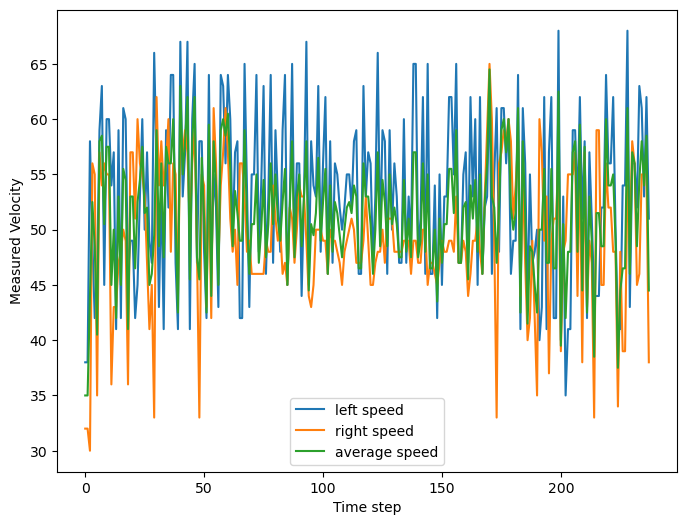

In [24]:
# example variance aquisition
import matplotlib.pyplot as plt
import numpy as np

# straight for translation data, in a circle for rotation data
acquire_data_trans = False  # set to True to acquire new data in translation from the Thymio robot
acquire_data_rot = False  # set to True to acquire new data in rotation from the Thymio robot
Ts = 0.1
thymio_data_trans = []
thymio_data_rot = []

def motors(left, right):
    return {
        "motor.left.target": [left],
        "motor.right.target": [right],
    }

def get_data_trans():
    thymio_data_trans.append({"ground":list(node["prox.ground.reflected"]), 
                        "sensor":list(node["prox.ground.reflected"]),
                        "left_speed":node["motor.left.speed"],
                        "right_speed":node["motor.right.speed"]})
    
def get_data_rot():
    thymio_data_rot.append({"ground":list(node["prox.ground.reflected"]), 
                        "sensor":list(node["prox.ground.reflected"]),
                        "left_speed":node["motor.left.speed"],
                        "right_speed":node["motor.right.speed"]})

# data that was acquired with the above functions
thymio_data_trans = [{'ground': [177, 496], 'sensor': [177, 496], 'left_speed': 0, 'right_speed': 65535}, {'ground': [178, 495], 'sensor': [178, 495], 'left_speed': 0, 'right_speed': 65535}, {'ground': [177, 495], 'sensor': [177, 495], 'left_speed': 0, 'right_speed': 65535}, {'ground': [177, 496], 'sensor': [177, 496], 'left_speed': 0, 'right_speed': 65535}, {'ground': [177, 495], 'sensor': [177, 495], 'left_speed': 0, 'right_speed': 65535}, {'ground': [178, 496], 'sensor': [178, 496], 'left_speed': 0, 'right_speed': 65535}, {'ground': [178, 495], 'sensor': [178, 495], 'left_speed': 0, 'right_speed': 65535}, {'ground': [177, 496], 'sensor': [177, 496], 'left_speed': 0, 'right_speed': 65535}, {'ground': [177, 496], 'sensor': [177, 496], 'left_speed': 0, 'right_speed': 65535}, {'ground': [178, 495], 'sensor': [178, 495], 'left_speed': 0, 'right_speed': 65535}, {'ground': [177, 495], 'sensor': [177, 495], 'left_speed': 0, 'right_speed': 65535}, {'ground': [177, 497], 'sensor': [177, 497], 'left_speed': 0, 'right_speed': 65535}, {'ground': [177, 495], 'sensor': [177, 495], 'left_speed': 0, 'right_speed': 65535}, {'ground': [177, 495], 'sensor': [177, 495], 'left_speed': 0, 'right_speed': 65535}, {'ground': [178, 496], 'sensor': [178, 496], 'left_speed': 0, 'right_speed': 65535}, {'ground': [180, 546], 'sensor': [180, 546], 'left_speed': 0, 'right_speed': 65535}, {'ground': [177, 454], 'sensor': [177, 454], 'left_speed': 0, 'right_speed': 65535}, {'ground': [97, 69], 'sensor': [97, 69], 'left_speed': 0, 'right_speed': 65535}, {'ground': [39, 41], 'sensor': [39, 41], 'left_speed': 0, 'right_speed': 0}, {'ground': [82, 47], 'sensor': [82, 47], 'left_speed': 0, 'right_speed': 65535}, {'ground': [34, 29], 'sensor': [34, 29], 'left_speed': 0, 'right_speed': 65535}, {'ground': [24, 9], 'sensor': [24, 9], 'left_speed': 0, 'right_speed': 65535}, {'ground': [899, 447], 'sensor': [899, 447], 'left_speed': 0, 'right_speed': 65535}, {'ground': [967, 631], 'sensor': [967, 631], 'left_speed': 0, 'right_speed': 65535}, {'ground': [972, 682], 'sensor': [972, 682], 'left_speed': 0, 'right_speed': 65535}, {'ground': [971, 675], 'sensor': [971, 675], 'left_speed': 0, 'right_speed': 65535}, {'ground': [970, 651], 'sensor': [970, 651], 'left_speed': 0, 'right_speed': 65535}, {'ground': [971, 642], 'sensor': [971, 642], 'left_speed': 0, 'right_speed': 65535}, {'ground': [970, 628], 'sensor': [970, 628], 'left_speed': 0, 'right_speed': 65535}, {'ground': [970, 628], 'sensor': [970, 628], 'left_speed': 0, 'right_speed': 65535}, {'ground': [970, 628], 'sensor': [970, 628], 'left_speed': 0, 'right_speed': 65535}, {'ground': [970, 627], 'sensor': [970, 627], 'left_speed': 0, 'right_speed': 65535}, {'ground': [970, 611], 'sensor': [970, 611], 'left_speed': 0, 'right_speed': 65535}, {'ground': [971, 604], 'sensor': [971, 604], 'left_speed': 0, 'right_speed': 0}, {'ground': [971, 598], 'sensor': [971, 598], 'left_speed': 0, 'right_speed': 65535}, {'ground': [972, 642], 'sensor': [972, 642], 'left_speed': 0, 'right_speed': 65535}, {'ground': [973, 714], 'sensor': [973, 714], 'left_speed': 0, 'right_speed': 65535}, {'ground': [973, 704], 'sensor': [973, 704], 'left_speed': 0, 'right_speed': 65535}, {'ground': [973, 702], 'sensor': [973, 702], 'left_speed': 0, 'right_speed': 0}, {'ground': [972, 700], 'sensor': [972, 700], 'left_speed': 0, 'right_speed': 65535}, {'ground': [973, 701], 'sensor': [973, 701], 'left_speed': 0, 'right_speed': 0}, {'ground': [974, 707], 'sensor': [974, 707], 'left_speed': 0, 'right_speed': 0}, {'ground': [974, 711], 'sensor': [974, 711], 'left_speed': 0, 'right_speed': 65535}, {'ground': [974, 707], 'sensor': [974, 707], 'left_speed': 0, 'right_speed': 65535}, {'ground': [972, 702], 'sensor': [972, 702], 'left_speed': 0, 'right_speed': 65535}, {'ground': [973, 686], 'sensor': [973, 686], 'left_speed': 0, 'right_speed': 65535}, {'ground': [972, 662], 'sensor': [972, 662], 'left_speed': 0, 'right_speed': 65535}, {'ground': [968, 602], 'sensor': [968, 602], 'left_speed': 0, 'right_speed': 65535}, {'ground': [954, 539], 'sensor': [954, 539], 'left_speed': 0, 'right_speed': 65535}, {'ground': [833, 464], 'sensor': [833, 464], 'left_speed': 0, 'right_speed': 65535}, {'ground': [826, 460], 'sensor': [826, 460], 'left_speed': 2, 'right_speed': 65535}, {'ground': [511, 244], 'sensor': [511, 244], 'left_speed': 39, 'right_speed': 31}, {'ground': [306, 131], 'sensor': [306, 131], 'left_speed': 49, 'right_speed': 35}, {'ground': [194, 87], 'sensor': [194, 87], 'left_speed': 58, 'right_speed': 57}, {'ground': [174, 84], 'sensor': [174, 84], 'left_speed': 64, 'right_speed': 42}, {'ground': [174, 84], 'sensor': [174, 84], 'left_speed': 38, 'right_speed': 32}, {'ground': [174, 84], 'sensor': [174, 84], 'left_speed': 38, 'right_speed': 32}, {'ground': [171, 84], 'sensor': [171, 84], 'left_speed': 58, 'right_speed': 30}, {'ground': [169, 81], 'sensor': [169, 81], 'left_speed': 49, 'right_speed': 56}, {'ground': [167, 80], 'sensor': [167, 80], 'left_speed': 42, 'right_speed': 55}, {'ground': [167, 81], 'sensor': [167, 81], 'left_speed': 46, 'right_speed': 35}, {'ground': [168, 80], 'sensor': [168, 80], 'left_speed': 59, 'right_speed': 57}, {'ground': [172, 81], 'sensor': [172, 81], 'left_speed': 63, 'right_speed': 54}, {'ground': [173, 84], 'sensor': [173, 84], 'left_speed': 45, 'right_speed': 56}, {'ground': [171, 84], 'sensor': [171, 84], 'left_speed': 60, 'right_speed': 55}, {'ground': [171, 84], 'sensor': [171, 84], 'left_speed': 60, 'right_speed': 55}, {'ground': [165, 84], 'sensor': [165, 84], 'left_speed': 54, 'right_speed': 36}, {'ground': [166, 86], 'sensor': [166, 86], 'left_speed': 57, 'right_speed': 43}, {'ground': [166, 86], 'sensor': [166, 86], 'left_speed': 41, 'right_speed': 43}, {'ground': [168, 87], 'sensor': [168, 87], 'left_speed': 59, 'right_speed': 47}, {'ground': [175, 96], 'sensor': [175, 96], 'left_speed': 42, 'right_speed': 48}, {'ground': [280, 157], 'sensor': [280, 157], 'left_speed': 61, 'right_speed': 50}, {'ground': [503, 262], 'sensor': [503, 262], 'left_speed': 60, 'right_speed': 49}, {'ground': [658, 355], 'sensor': [658, 355], 'left_speed': 46, 'right_speed': 36}, {'ground': [639, 345], 'sensor': [639, 345], 'left_speed': 49, 'right_speed': 57}, {'ground': [639, 345], 'sensor': [639, 345], 'left_speed': 49, 'right_speed': 57}, {'ground': [501, 257], 'sensor': [501, 257], 'left_speed': 42, 'right_speed': 51}, {'ground': [187, 88], 'sensor': [187, 88], 'left_speed': 45, 'right_speed': 60}, {'ground': [166, 85], 'sensor': [166, 85], 'left_speed': 53, 'right_speed': 56}, {'ground': [166, 84], 'sensor': [166, 84], 'left_speed': 60, 'right_speed': 55}, {'ground': [168, 84], 'sensor': [168, 84], 'left_speed': 50, 'right_speed': 53}, {'ground': [169, 85], 'sensor': [169, 85], 'left_speed': 57, 'right_speed': 47}, {'ground': [167, 87], 'sensor': [167, 87], 'left_speed': 49, 'right_speed': 41}, {'ground': [169, 86], 'sensor': [169, 86], 'left_speed': 47, 'right_speed': 45}, {'ground': [167, 84], 'sensor': [167, 84], 'left_speed': 66, 'right_speed': 33}, {'ground': [164, 85], 'sensor': [164, 85], 'left_speed': 56, 'right_speed': 62}, {'ground': [162, 85], 'sensor': [162, 85], 'left_speed': 43, 'right_speed': 54}, {'ground': [163, 85], 'sensor': [163, 85], 'left_speed': 54, 'right_speed': 58}, {'ground': [163, 85], 'sensor': [163, 85], 'left_speed': 41, 'right_speed': 54}, {'ground': [160, 84], 'sensor': [160, 84], 'left_speed': 59, 'right_speed': 56}, {'ground': [156, 82], 'sensor': [156, 82], 'left_speed': 52, 'right_speed': 60}, {'ground': [157, 82], 'sensor': [157, 82], 'left_speed': 64, 'right_speed': 48}, {'ground': [162, 83], 'sensor': [162, 83], 'left_speed': 64, 'right_speed': 56}, {'ground': [166, 82], 'sensor': [166, 82], 'left_speed': 47, 'right_speed': 55}, {'ground': [165, 91], 'sensor': [165, 91], 'left_speed': 41, 'right_speed': 44}, {'ground': [254, 156], 'sensor': [254, 156], 'left_speed': 67, 'right_speed': 59}, {'ground': [477, 279], 'sensor': [477, 279], 'left_speed': 53, 'right_speed': 57}, {'ground': [678, 391], 'sensor': [678, 391], 'left_speed': 57, 'right_speed': 59}, {'ground': [762, 426], 'sensor': [762, 426], 'left_speed': 67, 'right_speed': 57}, {'ground': [738, 394], 'sensor': [738, 394], 'left_speed': 41, 'right_speed': 50}, {'ground': [649, 332], 'sensor': [649, 332], 'left_speed': 60, 'right_speed': 56}, {'ground': [596, 319], 'sensor': [596, 319], 'left_speed': 65, 'right_speed': 59}, {'ground': [593, 321], 'sensor': [593, 321], 'left_speed': 47, 'right_speed': 48}, {'ground': [596, 325], 'sensor': [596, 325], 'left_speed': 58, 'right_speed': 33}, {'ground': [601, 330], 'sensor': [601, 330], 'left_speed': 58, 'right_speed': 55}, {'ground': [605, 331], 'sensor': [605, 331], 'left_speed': 48, 'right_speed': 54}, {'ground': [608, 331], 'sensor': [608, 331], 'left_speed': 42, 'right_speed': 43}, {'ground': [607, 330], 'sensor': [607, 330], 'left_speed': 64, 'right_speed': 55}, {'ground': [605, 329], 'sensor': [605, 329], 'left_speed': 46, 'right_speed': 42}, {'ground': [605, 329], 'sensor': [605, 329], 'left_speed': 55, 'right_speed': 61}, {'ground': [604, 330], 'sensor': [604, 330], 'left_speed': 52, 'right_speed': 56}, {'ground': [604, 330], 'sensor': [604, 330], 'left_speed': 43, 'right_speed': 47}, {'ground': [607, 331], 'sensor': [607, 331], 'left_speed': 64, 'right_speed': 54}, {'ground': [604, 332], 'sensor': [604, 332], 'left_speed': 63, 'right_speed': 57}, {'ground': [600, 334], 'sensor': [600, 334], 'left_speed': 56, 'right_speed': 61}, {'ground': [598, 335], 'sensor': [598, 335], 'left_speed': 64, 'right_speed': 57}, {'ground': [594, 337], 'sensor': [594, 337], 'left_speed': 60, 'right_speed': 51}, {'ground': [592, 339], 'sensor': [592, 339], 'left_speed': 49, 'right_speed': 48}, {'ground': [593, 350], 'sensor': [593, 350], 'left_speed': 57, 'right_speed': 50}, {'ground': [642, 404], 'sensor': [642, 404], 'left_speed': 58, 'right_speed': 45}, {'ground': [776, 487], 'sensor': [776, 487], 'left_speed': 42, 'right_speed': 56}, {'ground': [776, 487], 'sensor': [776, 487], 'left_speed': 42, 'right_speed': 56}, {'ground': [863, 531], 'sensor': [863, 531], 'left_speed': 65, 'right_speed': 53}, {'ground': [760, 410], 'sensor': [760, 410], 'left_speed': 54, 'right_speed': 48}, {'ground': [660, 363], 'sensor': [660, 363], 'left_speed': 43, 'right_speed': 49}, {'ground': [617, 364], 'sensor': [617, 364], 'left_speed': 55, 'right_speed': 46}, {'ground': [617, 364], 'sensor': [617, 364], 'left_speed': 55, 'right_speed': 46}, {'ground': [599, 356], 'sensor': [599, 356], 'left_speed': 64, 'right_speed': 46}, {'ground': [600, 348], 'sensor': [600, 348], 'left_speed': 48, 'right_speed': 46}, {'ground': [604, 343], 'sensor': [604, 343], 'left_speed': 54, 'right_speed': 46}, {'ground': [601, 340], 'sensor': [601, 340], 'left_speed': 63, 'right_speed': 46}, {'ground': [598, 339], 'sensor': [598, 339], 'left_speed': 46, 'right_speed': 49}, {'ground': [594, 340], 'sensor': [594, 340], 'left_speed': 53, 'right_speed': 48}, {'ground': [590, 343], 'sensor': [590, 343], 'left_speed': 64, 'right_speed': 48}, {'ground': [592, 347], 'sensor': [592, 347], 'left_speed': 47, 'right_speed': 54}, {'ground': [594, 348], 'sensor': [594, 348], 'left_speed': 59, 'right_speed': 51}, {'ground': [595, 352], 'sensor': [595, 352], 'left_speed': 53, 'right_speed': 49}, {'ground': [598, 352], 'sensor': [598, 352], 'left_speed': 48, 'right_speed': 50}, {'ground': [601, 352], 'sensor': [601, 352], 'left_speed': 59, 'right_speed': 46}, {'ground': [604, 354], 'sensor': [604, 354], 'left_speed': 64, 'right_speed': 47}, {'ground': [605, 354], 'sensor': [605, 354], 'left_speed': 45, 'right_speed': 45}, {'ground': [617, 386], 'sensor': [617, 386], 'left_speed': 52, 'right_speed': 52}, {'ground': [702, 466], 'sensor': [702, 466], 'left_speed': 65, 'right_speed': 51}, {'ground': [831, 497], 'sensor': [831, 497], 'left_speed': 48, 'right_speed': 47}, {'ground': [774, 398], 'sensor': [774, 398], 'left_speed': 56, 'right_speed': 50}, {'ground': [603, 234], 'sensor': [603, 234], 'left_speed': 56, 'right_speed': 54}, {'ground': [382, 118], 'sensor': [382, 118], 'left_speed': 44, 'right_speed': 53}, {'ground': [213, 97], 'sensor': [213, 97], 'left_speed': 53, 'right_speed': 53}, {'ground': [184, 100], 'sensor': [184, 100], 'left_speed': 67, 'right_speed': 49}, {'ground': [186, 99], 'sensor': [186, 99], 'left_speed': 45, 'right_speed': 44}, {'ground': [186, 98], 'sensor': [186, 98], 'left_speed': 58, 'right_speed': 43}, {'ground': [189, 98], 'sensor': [189, 98], 'left_speed': 54, 'right_speed': 45}, {'ground': [190, 94], 'sensor': [190, 94], 'left_speed': 53, 'right_speed': 50}, {'ground': [188, 91], 'sensor': [188, 91], 'left_speed': 63, 'right_speed': 50}, {'ground': [184, 93], 'sensor': [184, 93], 'left_speed': 48, 'right_speed': 50}, {'ground': [187, 92], 'sensor': [187, 92], 'left_speed': 56, 'right_speed': 49}, {'ground': [189, 92], 'sensor': [189, 92], 'left_speed': 62, 'right_speed': 49}, {'ground': [202, 94], 'sensor': [202, 94], 'left_speed': 46, 'right_speed': 46}, {'ground': [172, 95], 'sensor': [172, 95], 'left_speed': 58, 'right_speed': 50}, {'ground': [176, 78], 'sensor': [176, 78], 'left_speed': 47, 'right_speed': 49}, {'ground': [177, 79], 'sensor': [177, 79], 'left_speed': 56, 'right_speed': 49}, {'ground': [171, 72], 'sensor': [171, 72], 'left_speed': 55, 'right_speed': 48}, {'ground': [159, 87], 'sensor': [159, 87], 'left_speed': 52, 'right_speed': 47}, {'ground': [169, 165], 'sensor': [169, 165], 'left_speed': 50, 'right_speed': 45}, {'ground': [304, 285], 'sensor': [304, 285], 'left_speed': 52, 'right_speed': 48}, {'ground': [548, 374], 'sensor': [548, 374], 'left_speed': 55, 'right_speed': 49}, {'ground': [663, 354], 'sensor': [663, 354], 'left_speed': 55, 'right_speed': 50}, {'ground': [586, 206], 'sensor': [586, 206], 'left_speed': 52, 'right_speed': 51}, {'ground': [403, 93], 'sensor': [403, 93], 'left_speed': 58, 'right_speed': 50}, {'ground': [225, 84], 'sensor': [225, 84], 'left_speed': 59, 'right_speed': 47}, {'ground': [181, 91], 'sensor': [181, 91], 'left_speed': 46, 'right_speed': 47}, {'ground': [181, 91], 'sensor': [181, 91], 'left_speed': 46, 'right_speed': 47}, {'ground': [179, 99], 'sensor': [179, 99], 'left_speed': 63, 'right_speed': 49}, {'ground': [192, 98], 'sensor': [192, 98], 'left_speed': 53, 'right_speed': 53}, {'ground': [194, 95], 'sensor': [194, 95], 'left_speed': 57, 'right_speed': 49}, {'ground': [183, 91], 'sensor': [183, 91], 'left_speed': 56, 'right_speed': 45}, {'ground': [176, 89], 'sensor': [176, 89], 'left_speed': 47, 'right_speed': 45}, {'ground': [175, 90], 'sensor': [175, 90], 'left_speed': 53, 'right_speed': 47}, {'ground': [178, 92], 'sensor': [178, 92], 'left_speed': 66, 'right_speed': 48}, {'ground': [177, 94], 'sensor': [177, 94], 'left_speed': 49, 'right_speed': 48}, {'ground': [180, 90], 'sensor': [180, 90], 'left_speed': 59, 'right_speed': 50}, {'ground': [181, 88], 'sensor': [181, 88], 'left_speed': 58, 'right_speed': 47}, {'ground': [179, 87], 'sensor': [179, 87], 'left_speed': 46, 'right_speed': 51}, {'ground': [181, 90], 'sensor': [181, 90], 'left_speed': 59, 'right_speed': 51}, {'ground': [189, 100], 'sensor': [189, 100], 'left_speed': 50, 'right_speed': 51}, {'ground': [193, 153], 'sensor': [193, 153], 'left_speed': 56, 'right_speed': 48}, {'ground': [317, 316], 'sensor': [317, 316], 'left_speed': 53, 'right_speed': 48}, {'ground': [605, 412], 'sensor': [605, 412], 'left_speed': 47, 'right_speed': 48}, {'ground': [605, 412], 'sensor': [605, 412], 'left_speed': 47, 'right_speed': 48}, {'ground': [684, 335], 'sensor': [684, 335], 'left_speed': 60, 'right_speed': 49}, {'ground': [575, 174], 'sensor': [575, 174], 'left_speed': 47, 'right_speed': 49}, {'ground': [224, 86], 'sensor': [224, 86], 'left_speed': 53, 'right_speed': 49}, {'ground': [180, 86], 'sensor': [180, 86], 'left_speed': 49, 'right_speed': 46}, {'ground': [175, 85], 'sensor': [175, 85], 'left_speed': 65, 'right_speed': 49}, {'ground': [175, 85], 'sensor': [175, 85], 'left_speed': 65, 'right_speed': 49}, {'ground': [177, 86], 'sensor': [177, 86], 'left_speed': 48, 'right_speed': 47}, {'ground': [182, 88], 'sensor': [182, 88], 'left_speed': 51, 'right_speed': 47}, {'ground': [181, 87], 'sensor': [181, 87], 'left_speed': 62, 'right_speed': 50}, {'ground': [176, 86], 'sensor': [176, 86], 'left_speed': 46, 'right_speed': 50}, {'ground': [177, 89], 'sensor': [177, 89], 'left_speed': 65, 'right_speed': 45}, {'ground': [183, 94], 'sensor': [183, 94], 'left_speed': 46, 'right_speed': 47}, {'ground': [183, 94], 'sensor': [183, 94], 'left_speed': 46, 'right_speed': 47}, {'ground': [189, 96], 'sensor': [189, 96], 'left_speed': 54, 'right_speed': 46}, {'ground': [189, 97], 'sensor': [189, 97], 'left_speed': 42, 'right_speed': 45}, {'ground': [188, 96], 'sensor': [188, 96], 'left_speed': 55, 'right_speed': 47}, {'ground': [189, 97], 'sensor': [189, 97], 'left_speed': 45, 'right_speed': 49}, {'ground': [190, 101], 'sensor': [190, 101], 'left_speed': 53, 'right_speed': 48}, {'ground': [190, 101], 'sensor': [190, 101], 'left_speed': 53, 'right_speed': 48}, {'ground': [241, 318], 'sensor': [241, 318], 'left_speed': 62, 'right_speed': 49}, {'ground': [241, 318], 'sensor': [241, 318], 'left_speed': 62, 'right_speed': 49}, {'ground': [770, 478], 'sensor': [770, 478], 'left_speed': 55, 'right_speed': 48}, {'ground': [815, 401], 'sensor': [815, 401], 'left_speed': 65, 'right_speed': 53}, {'ground': [753, 350], 'sensor': [753, 350], 'left_speed': 47, 'right_speed': 47}, {'ground': [753, 350], 'sensor': [753, 350], 'left_speed': 47, 'right_speed': 47}, {'ground': [658, 346], 'sensor': [658, 346], 'left_speed': 55, 'right_speed': 49}, {'ground': [616, 344], 'sensor': [616, 344], 'left_speed': 57, 'right_speed': 48}, {'ground': [612, 342], 'sensor': [612, 342], 'left_speed': 47, 'right_speed': 44}, {'ground': [608, 344], 'sensor': [608, 344], 'left_speed': 62, 'right_speed': 46}, {'ground': [606, 341], 'sensor': [606, 341], 'left_speed': 53, 'right_speed': 49}, {'ground': [604, 342], 'sensor': [604, 342], 'left_speed': 60, 'right_speed': 49}, {'ground': [604, 340], 'sensor': [604, 340], 'left_speed': 45, 'right_speed': 51}, {'ground': [597, 339], 'sensor': [597, 339], 'left_speed': 62, 'right_speed': 48}, {'ground': [592, 335], 'sensor': [592, 335], 'left_speed': 46, 'right_speed': 46}, {'ground': [590, 332], 'sensor': [590, 332], 'left_speed': 52, 'right_speed': 53}, {'ground': [589, 333], 'sensor': [589, 333], 'left_speed': 53, 'right_speed': 59}, {'ground': [591, 333], 'sensor': [591, 333], 'left_speed': 64, 'right_speed': 65}, {'ground': [592, 333], 'sensor': [592, 333], 'left_speed': 46, 'right_speed': 60}, {'ground': [591, 333], 'sensor': [591, 333], 'left_speed': 55, 'right_speed': 49}, {'ground': [594, 334], 'sensor': [594, 334], 'left_speed': 61, 'right_speed': 33}, {'ground': [597, 360], 'sensor': [597, 360], 'left_speed': 48, 'right_speed': 56}, {'ground': [601, 431], 'sensor': [601, 431], 'left_speed': 61, 'right_speed': 57}, {'ground': [639, 549], 'sensor': [639, 549], 'left_speed': 61, 'right_speed': 59}, {'ground': [776, 671], 'sensor': [776, 671], 'left_speed': 56, 'right_speed': 58}, {'ground': [943, 750], 'sensor': [943, 750], 'left_speed': 60, 'right_speed': 60}, {'ground': [967, 768], 'sensor': [967, 768], 'left_speed': 46, 'right_speed': 58}, {'ground': [972, 770], 'sensor': [972, 770], 'left_speed': 49, 'right_speed': 51}, {'ground': [974, 770], 'sensor': [974, 770], 'left_speed': 49, 'right_speed': 54}, {'ground': [973, 769], 'sensor': [973, 769], 'left_speed': 64, 'right_speed': 58}, {'ground': [973, 770], 'sensor': [973, 770], 'left_speed': 41, 'right_speed': 44}, {'ground': [974, 768], 'sensor': [974, 768], 'left_speed': 61, 'right_speed': 55}, {'ground': [973, 757], 'sensor': [973, 757], 'left_speed': 56, 'right_speed': 47}, {'ground': [974, 736], 'sensor': [974, 736], 'left_speed': 43, 'right_speed': 40}, {'ground': [974, 708], 'sensor': [974, 708], 'left_speed': 55, 'right_speed': 42}, {'ground': [972, 720], 'sensor': [972, 720], 'left_speed': 47, 'right_speed': 49}, {'ground': [970, 716], 'sensor': [970, 716], 'left_speed': 48, 'right_speed': 42}, {'ground': [972, 708], 'sensor': [972, 708], 'left_speed': 50, 'right_speed': 35}, {'ground': [970, 702], 'sensor': [970, 702], 'left_speed': 40, 'right_speed': 60}, {'ground': [970, 702], 'sensor': [970, 702], 'left_speed': 43, 'right_speed': 57}, {'ground': [969, 694], 'sensor': [969, 694], 'left_speed': 62, 'right_speed': 49}, {'ground': [968, 692], 'sensor': [968, 692], 'left_speed': 41, 'right_speed': 53}, {'ground': [968, 702], 'sensor': [968, 702], 'left_speed': 57, 'right_speed': 37}, {'ground': [968, 712], 'sensor': [968, 712], 'left_speed': 62, 'right_speed': 49}, {'ground': [970, 738], 'sensor': [970, 738], 'left_speed': 42, 'right_speed': 51}, {'ground': [970, 738], 'sensor': [970, 738], 'left_speed': 42, 'right_speed': 51}, {'ground': [970, 751], 'sensor': [970, 751], 'left_speed': 68, 'right_speed': 57}, {'ground': [970, 746], 'sensor': [970, 746], 'left_speed': 40, 'right_speed': 39}, {'ground': [970, 744], 'sensor': [970, 744], 'left_speed': 53, 'right_speed': 48}, {'ground': [972, 728], 'sensor': [972, 728], 'left_speed': 35, 'right_speed': 49}, {'ground': [971, 729], 'sensor': [971, 729], 'left_speed': 41, 'right_speed': 55}, {'ground': [971, 729], 'sensor': [971, 729], 'left_speed': 41, 'right_speed': 55}, {'ground': [970, 727], 'sensor': [970, 727], 'left_speed': 59, 'right_speed': 55}, {'ground': [971, 727], 'sensor': [971, 727], 'left_speed': 59, 'right_speed': 57}, {'ground': [970, 738], 'sensor': [970, 738], 'left_speed': 52, 'right_speed': 44}, {'ground': [970, 724], 'sensor': [970, 724], 'left_speed': 62, 'right_speed': 57}, {'ground': [970, 708], 'sensor': [970, 708], 'left_speed': 51, 'right_speed': 38}, {'ground': [970, 719], 'sensor': [970, 719], 'left_speed': 58, 'right_speed': 57}, {'ground': [970, 702], 'sensor': [970, 702], 'left_speed': 42, 'right_speed': 43}, {'ground': [970, 715], 'sensor': [970, 715], 'left_speed': 57, 'right_speed': 49}, {'ground': [970, 705], 'sensor': [970, 705], 'left_speed': 51, 'right_speed': 47}, {'ground': [970, 713], 'sensor': [970, 713], 'left_speed': 44, 'right_speed': 33}, {'ground': [970, 695], 'sensor': [970, 695], 'left_speed': 44, 'right_speed': 59}, {'ground': [970, 695], 'sensor': [970, 695], 'left_speed': 44, 'right_speed': 59}, {'ground': [970, 707], 'sensor': [970, 707], 'left_speed': 52, 'right_speed': 45}, {'ground': [970, 707], 'sensor': [970, 707], 'left_speed': 52, 'right_speed': 45}, {'ground': [970, 718], 'sensor': [970, 718], 'left_speed': 64, 'right_speed': 56}, {'ground': [970, 705], 'sensor': [970, 705], 'left_speed': 56, 'right_speed': 52}, {'ground': [970, 705], 'sensor': [970, 705], 'left_speed': 56, 'right_speed': 52}, {'ground': [970, 695], 'sensor': [970, 695], 'left_speed': 62, 'right_speed': 48}, {'ground': [970, 702], 'sensor': [970, 702], 'left_speed': 50, 'right_speed': 48}, {'ground': [969, 712], 'sensor': [969, 712], 'left_speed': 41, 'right_speed': 34}, {'ground': [970, 708], 'sensor': [970, 708], 'left_speed': 41, 'right_speed': 48}, {'ground': [970, 703], 'sensor': [970, 703], 'left_speed': 54, 'right_speed': 39}, {'ground': [970, 703], 'sensor': [970, 703], 'left_speed': 54, 'right_speed': 39}, {'ground': [970, 703], 'sensor': [970, 703], 'left_speed': 68, 'right_speed': 54}, {'ground': [971, 698], 'sensor': [971, 698], 'left_speed': 43, 'right_speed': 49}, {'ground': [970, 682], 'sensor': [970, 682], 'left_speed': 56, 'right_speed': 58}, {'ground': [969, 679], 'sensor': [969, 679], 'left_speed': 56, 'right_speed': 56}, {'ground': [968, 685], 'sensor': [968, 685], 'left_speed': 52, 'right_speed': 45}, {'ground': [969, 702], 'sensor': [969, 702], 'left_speed': 63, 'right_speed': 46}, {'ground': [970, 712], 'sensor': [970, 712], 'left_speed': 61, 'right_speed': 55}, {'ground': [970, 738], 'sensor': [970, 738], 'left_speed': 53, 'right_speed': 55}, {'ground': [970, 732], 'sensor': [970, 732], 'left_speed': 62, 'right_speed': 55}, {'ground': [970, 731], 'sensor': [970, 731], 'left_speed': 51, 'right_speed': 38}]
 
thymio_data_rot = [{'ground': [63, 87], 'sensor': [63, 87], 'left_speed': 0, 'right_speed': 0}, {'ground': [64, 87], 'sensor': [64, 87], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [68, 83], 'sensor': [68, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [68, 83], 'sensor': [68, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 0, 'right_speed': 0}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 27, 'right_speed': -30}, {'ground': [67, 83], 'sensor': [67, 83], 'left_speed': 27, 'right_speed': -30}, {'ground': [64, 83], 'sensor': [64, 83], 'left_speed': 36, 'right_speed': -41}, {'ground': [64, 83], 'sensor': [64, 83], 'left_speed': 36, 'right_speed': -41}, {'ground': [64, 83], 'sensor': [64, 83], 'left_speed': 36, 'right_speed': -41}, {'ground': [66, 89], 'sensor': [66, 89], 'left_speed': 51, 'right_speed': -44}, {'ground': [66, 89], 'sensor': [66, 89], 'left_speed': 51, 'right_speed': -44}, {'ground': [65, 94], 'sensor': [65, 94], 'left_speed': 51, 'right_speed': -42}, {'ground': [66, 402], 'sensor': [66, 402], 'left_speed': 49, 'right_speed': -48}, {'ground': [66, 402], 'sensor': [66, 402], 'left_speed': 49, 'right_speed': -48}, {'ground': [66, 853], 'sensor': [66, 853], 'left_speed': 51, 'right_speed': -50}, {'ground': [66, 853], 'sensor': [66, 853], 'left_speed': 51, 'right_speed': -50}, {'ground': [72, 873], 'sensor': [72, 873], 'left_speed': 50, 'right_speed': -49}, {'ground': [72, 873], 'sensor': [72, 873], 'left_speed': 50, 'right_speed': -49}, {'ground': [121, 872], 'sensor': [121, 872], 'left_speed': 50, 'right_speed': -55}, {'ground': [121, 872], 'sensor': [121, 872], 'left_speed': 50, 'right_speed': -55}, {'ground': [543, 865], 'sensor': [543, 865], 'left_speed': 49, 'right_speed': -48}, {'ground': [543, 865], 'sensor': [543, 865], 'left_speed': 49, 'right_speed': -48}, {'ground': [653, 858], 'sensor': [653, 858], 'left_speed': 48, 'right_speed': -51}, {'ground': [653, 858], 'sensor': [653, 858], 'left_speed': 48, 'right_speed': -51}, {'ground': [665, 851], 'sensor': [665, 851], 'left_speed': 51, 'right_speed': -50}, {'ground': [665, 851], 'sensor': [665, 851], 'left_speed': 51, 'right_speed': -50}, {'ground': [653, 849], 'sensor': [653, 849], 'left_speed': 50, 'right_speed': -49}, {'ground': [653, 849], 'sensor': [653, 849], 'left_speed': 50, 'right_speed': -49}, {'ground': [649, 853], 'sensor': [649, 853], 'left_speed': 51, 'right_speed': -47}, {'ground': [649, 853], 'sensor': [649, 853], 'left_speed': 51, 'right_speed': -47}, {'ground': [644, 855], 'sensor': [644, 855], 'left_speed': 51, 'right_speed': -52}, {'ground': [644, 855], 'sensor': [644, 855], 'left_speed': 51, 'right_speed': -52}, {'ground': [648, 857], 'sensor': [648, 857], 'left_speed': 51, 'right_speed': -53}, {'ground': [648, 857], 'sensor': [648, 857], 'left_speed': 51, 'right_speed': -53}, {'ground': [648, 863], 'sensor': [648, 863], 'left_speed': 51, 'right_speed': -53}, {'ground': [648, 863], 'sensor': [648, 863], 'left_speed': 51, 'right_speed': -53}, {'ground': [655, 865], 'sensor': [655, 865], 'left_speed': 52, 'right_speed': -52}, {'ground': [655, 865], 'sensor': [655, 865], 'left_speed': 52, 'right_speed': -52}, {'ground': [655, 863], 'sensor': [655, 863], 'left_speed': 51, 'right_speed': -51}, {'ground': [655, 863], 'sensor': [655, 863], 'left_speed': 51, 'right_speed': -51}, {'ground': [658, 863], 'sensor': [658, 863], 'left_speed': 51, 'right_speed': -56}, {'ground': [658, 863], 'sensor': [658, 863], 'left_speed': 51, 'right_speed': -56}, {'ground': [663, 860], 'sensor': [663, 860], 'left_speed': 50, 'right_speed': -54}, {'ground': [663, 860], 'sensor': [663, 860], 'left_speed': 50, 'right_speed': -54}, {'ground': [660, 862], 'sensor': [660, 862], 'left_speed': 49, 'right_speed': -45}, {'ground': [660, 862], 'sensor': [660, 862], 'left_speed': 49, 'right_speed': -45}, {'ground': [665, 863], 'sensor': [665, 863], 'left_speed': 47, 'right_speed': -53}, {'ground': [665, 863], 'sensor': [665, 863], 'left_speed': 47, 'right_speed': -53}, {'ground': [659, 863], 'sensor': [659, 863], 'left_speed': 49, 'right_speed': -49}, {'ground': [659, 863], 'sensor': [659, 863], 'left_speed': 49, 'right_speed': -49}, {'ground': [657, 859], 'sensor': [657, 859], 'left_speed': 48, 'right_speed': -45}, {'ground': [657, 859], 'sensor': [657, 859], 'left_speed': 48, 'right_speed': -45}, {'ground': [659, 859], 'sensor': [659, 859], 'left_speed': 50, 'right_speed': -46}, {'ground': [659, 859], 'sensor': [659, 859], 'left_speed': 50, 'right_speed': -46}, {'ground': [661, 869], 'sensor': [661, 869], 'left_speed': 50, 'right_speed': -48}, {'ground': [660, 885], 'sensor': [660, 885], 'left_speed': 52, 'right_speed': -50}, {'ground': [660, 885], 'sensor': [660, 885], 'left_speed': 52, 'right_speed': -50}, {'ground': [656, 899], 'sensor': [656, 899], 'left_speed': 52, 'right_speed': -52}, {'ground': [656, 899], 'sensor': [656, 899], 'left_speed': 52, 'right_speed': -52}, {'ground': [656, 899], 'sensor': [656, 899], 'left_speed': 52, 'right_speed': -52}, {'ground': [659, 905], 'sensor': [659, 905], 'left_speed': 51, 'right_speed': -43}, {'ground': [659, 905], 'sensor': [659, 905], 'left_speed': 51, 'right_speed': -43}, {'ground': [660, 802], 'sensor': [660, 802], 'left_speed': 50, 'right_speed': -49}, {'ground': [660, 802], 'sensor': [660, 802], 'left_speed': 50, 'right_speed': -49}, {'ground': [669, 419], 'sensor': [669, 419], 'left_speed': 51, 'right_speed': -53}, {'ground': [669, 419], 'sensor': [669, 419], 'left_speed': 51, 'right_speed': -53}, {'ground': [665, 387], 'sensor': [665, 387], 'left_speed': 50, 'right_speed': -52}, {'ground': [665, 387], 'sensor': [665, 387], 'left_speed': 50, 'right_speed': -52}, {'ground': [664, 375], 'sensor': [664, 375], 'left_speed': 49, 'right_speed': -54}, {'ground': [664, 375], 'sensor': [664, 375], 'left_speed': 49, 'right_speed': -54}, {'ground': [452, 370], 'sensor': [452, 370], 'left_speed': 50, 'right_speed': -51}, {'ground': [452, 370], 'sensor': [452, 370], 'left_speed': 50, 'right_speed': -51}, {'ground': [296, 372], 'sensor': [296, 372], 'left_speed': 49, 'right_speed': -44}, {'ground': [296, 372], 'sensor': [296, 372], 'left_speed': 49, 'right_speed': -44}, {'ground': [280, 380], 'sensor': [280, 380], 'left_speed': 50, 'right_speed': -43}, {'ground': [274, 377], 'sensor': [274, 377], 'left_speed': 49, 'right_speed': -45}, {'ground': [274, 377], 'sensor': [274, 377], 'left_speed': 49, 'right_speed': -45}, {'ground': [271, 380], 'sensor': [271, 380], 'left_speed': 50, 'right_speed': -47}, {'ground': [271, 380], 'sensor': [271, 380], 'left_speed': 50, 'right_speed': -47}, {'ground': [278, 391], 'sensor': [278, 391], 'left_speed': 52, 'right_speed': -51}, {'ground': [278, 391], 'sensor': [278, 391], 'left_speed': 52, 'right_speed': -51}, {'ground': [278, 391], 'sensor': [278, 391], 'left_speed': 52, 'right_speed': -51}, {'ground': [282, 384], 'sensor': [282, 384], 'left_speed': 50, 'right_speed': -55}, {'ground': [282, 384], 'sensor': [282, 384], 'left_speed': 50, 'right_speed': -55}, {'ground': [286, 382], 'sensor': [286, 382], 'left_speed': 51, 'right_speed': -48}, {'ground': [286, 382], 'sensor': [286, 382], 'left_speed': 51, 'right_speed': -48}, {'ground': [295, 375], 'sensor': [295, 375], 'left_speed': 52, 'right_speed': -53}, {'ground': [295, 375], 'sensor': [295, 375], 'left_speed': 52, 'right_speed': -53}, {'ground': [290, 389], 'sensor': [290, 389], 'left_speed': 51, 'right_speed': -52}, {'ground': [290, 389], 'sensor': [290, 389], 'left_speed': 51, 'right_speed': -52}, {'ground': [286, 415], 'sensor': [286, 415], 'left_speed': 50, 'right_speed': -53}, {'ground': [286, 415], 'sensor': [286, 415], 'left_speed': 50, 'right_speed': -53}, {'ground': [287, 564], 'sensor': [287, 564], 'left_speed': 49, 'right_speed': -48}, {'ground': [285, 489], 'sensor': [285, 489], 'left_speed': 47, 'right_speed': -48}, {'ground': [285, 489], 'sensor': [285, 489], 'left_speed': 47, 'right_speed': -48}, {'ground': [300, 395], 'sensor': [300, 395], 'left_speed': 50, 'right_speed': -53}, {'ground': [300, 395], 'sensor': [300, 395], 'left_speed': 50, 'right_speed': -53}, {'ground': [409, 390], 'sensor': [409, 390], 'left_speed': 51, 'right_speed': -52}, {'ground': [409, 390], 'sensor': [409, 390], 'left_speed': 51, 'right_speed': -52}, {'ground': [409, 390], 'sensor': [409, 390], 'left_speed': 51, 'right_speed': -52}, {'ground': [464, 390], 'sensor': [464, 390], 'left_speed': 48, 'right_speed': -50}, {'ground': [464, 390], 'sensor': [464, 390], 'left_speed': 48, 'right_speed': -50}, {'ground': [325, 386], 'sensor': [325, 386], 'left_speed': 49, 'right_speed': -52}, {'ground': [325, 386], 'sensor': [325, 386], 'left_speed': 49, 'right_speed': -52}, {'ground': [293, 388], 'sensor': [293, 388], 'left_speed': 48, 'right_speed': -49}, {'ground': [293, 388], 'sensor': [293, 388], 'left_speed': 48, 'right_speed': -49}, {'ground': [294, 390], 'sensor': [294, 390], 'left_speed': 50, 'right_speed': -51}, {'ground': [294, 390], 'sensor': [294, 390], 'left_speed': 50, 'right_speed': -51}, {'ground': [291, 393], 'sensor': [291, 393], 'left_speed': 50, 'right_speed': -51}, {'ground': [291, 393], 'sensor': [291, 393], 'left_speed': 50, 'right_speed': -51}, {'ground': [290, 428], 'sensor': [290, 428], 'left_speed': 48, 'right_speed': -50}, {'ground': [290, 428], 'sensor': [290, 428], 'left_speed': 48, 'right_speed': -50}, {'ground': [289, 517], 'sensor': [289, 517], 'left_speed': 49, 'right_speed': -49}, {'ground': [292, 100], 'sensor': [292, 100], 'left_speed': 50, 'right_speed': -50}, {'ground': [292, 100], 'sensor': [292, 100], 'left_speed': 50, 'right_speed': -50}, {'ground': [297, 95], 'sensor': [297, 95], 'left_speed': 51, 'right_speed': -51}, {'ground': [297, 95], 'sensor': [297, 95], 'left_speed': 51, 'right_speed': -51}, {'ground': [414, 93], 'sensor': [414, 93], 'left_speed': 51, 'right_speed': -50}, {'ground': [414, 93], 'sensor': [414, 93], 'left_speed': 51, 'right_speed': -50}, {'ground': [76, 92], 'sensor': [76, 92], 'left_speed': 50, 'right_speed': -51}, {'ground': [76, 92], 'sensor': [76, 92], 'left_speed': 50, 'right_speed': -51}, {'ground': [72, 94], 'sensor': [72, 94], 'left_speed': 50, 'right_speed': -53}, {'ground': [72, 94], 'sensor': [72, 94], 'left_speed': 50, 'right_speed': -53}, {'ground': [73, 93], 'sensor': [73, 93], 'left_speed': 51, 'right_speed': -51}, {'ground': [73, 93], 'sensor': [73, 93], 'left_speed': 51, 'right_speed': -51}, {'ground': [73, 93], 'sensor': [73, 93], 'left_speed': 51, 'right_speed': -51}, {'ground': [72, 128], 'sensor': [72, 128], 'left_speed': 51, 'right_speed': -52}, {'ground': [72, 128], 'sensor': [72, 128], 'left_speed': 51, 'right_speed': -52}, {'ground': [72, 467], 'sensor': [72, 467], 'left_speed': 51, 'right_speed': -51}, {'ground': [72, 467], 'sensor': [72, 467], 'left_speed': 51, 'right_speed': -51}, {'ground': [69, 189], 'sensor': [69, 189], 'left_speed': 50, 'right_speed': -49}, {'ground': [69, 189], 'sensor': [69, 189], 'left_speed': 50, 'right_speed': -49}, {'ground': [71, 93], 'sensor': [71, 93], 'left_speed': 49, 'right_speed': -50}, {'ground': [238, 90], 'sensor': [238, 90], 'left_speed': 50, 'right_speed': -49}, {'ground': [238, 90], 'sensor': [238, 90], 'left_speed': 50, 'right_speed': -49}, {'ground': [264, 86], 'sensor': [264, 86], 'left_speed': 51, 'right_speed': -49}, {'ground': [264, 86], 'sensor': [264, 86], 'left_speed': 51, 'right_speed': -49}, {'ground': [75, 90], 'sensor': [75, 90], 'left_speed': 49, 'right_speed': -49}, {'ground': [75, 90], 'sensor': [75, 90], 'left_speed': 49, 'right_speed': -49}, {'ground': [69, 91], 'sensor': [69, 91], 'left_speed': 47, 'right_speed': -50}, {'ground': [69, 91], 'sensor': [69, 91], 'left_speed': 47, 'right_speed': -50}, {'ground': [68, 88], 'sensor': [68, 88], 'left_speed': 50, 'right_speed': -52}, {'ground': [68, 88], 'sensor': [68, 88], 'left_speed': 50, 'right_speed': -52}, {'ground': [65, 92], 'sensor': [65, 92], 'left_speed': 49, 'right_speed': -51}, {'ground': [65, 92], 'sensor': [65, 92], 'left_speed': 49, 'right_speed': -51}, {'ground': [68, 86], 'sensor': [68, 86], 'left_speed': 51, 'right_speed': -50}, {'ground': [68, 86], 'sensor': [68, 86], 'left_speed': 51, 'right_speed': -50}, {'ground': [69, 84], 'sensor': [69, 84], 'left_speed': 51, 'right_speed': -49}, {'ground': [69, 84], 'sensor': [69, 84], 'left_speed': 51, 'right_speed': -49}, {'ground': [70, 88], 'sensor': [70, 88], 'left_speed': 51, 'right_speed': -50}, {'ground': [70, 88], 'sensor': [70, 88], 'left_speed': 51, 'right_speed': -50}, {'ground': [70, 85], 'sensor': [70, 85], 'left_speed': 50, 'right_speed': -50}, {'ground': [65, 87], 'sensor': [65, 87], 'left_speed': 50, 'right_speed': -51}, {'ground': [65, 87], 'sensor': [65, 87], 'left_speed': 50, 'right_speed': -51}, {'ground': [65, 87], 'sensor': [65, 87], 'left_speed': 50, 'right_speed': -51}, {'ground': [66, 84], 'sensor': [66, 84], 'left_speed': 49, 'right_speed': -52}, {'ground': [66, 84], 'sensor': [66, 84], 'left_speed': 49, 'right_speed': -52}, {'ground': [65, 85], 'sensor': [65, 85], 'left_speed': 50, 'right_speed': -51}, {'ground': [65, 85], 'sensor': [65, 85], 'left_speed': 50, 'right_speed': -51}, {'ground': [65, 88], 'sensor': [65, 88], 'left_speed': 52, 'right_speed': -51}, {'ground': [65, 88], 'sensor': [65, 88], 'left_speed': 52, 'right_speed': -51}, {'ground': [66, 97], 'sensor': [66, 97], 'left_speed': 50, 'right_speed': -55}, {'ground': [66, 97], 'sensor': [66, 97], 'left_speed': 50, 'right_speed': -55}, {'ground': [66, 498], 'sensor': [66, 498], 'left_speed': 49, 'right_speed': -53}, {'ground': [66, 498], 'sensor': [66, 498], 'left_speed': 49, 'right_speed': -53}, {'ground': [68, 857], 'sensor': [68, 857], 'left_speed': 48, 'right_speed': -49}, {'ground': [68, 857], 'sensor': [68, 857], 'left_speed': 48, 'right_speed': -49}, {'ground': [72, 873], 'sensor': [72, 873], 'left_speed': 49, 'right_speed': -45}, {'ground': [72, 873], 'sensor': [72, 873], 'left_speed': 49, 'right_speed': -45}, {'ground': [140, 869], 'sensor': [140, 869], 'left_speed': 49, 'right_speed': -47}, {'ground': [140, 869], 'sensor': [140, 869], 'left_speed': 49, 'right_speed': -47}, {'ground': [564, 863], 'sensor': [564, 863], 'left_speed': 51, 'right_speed': -47}, {'ground': [654, 856], 'sensor': [654, 856], 'left_speed': 50, 'right_speed': -48}, {'ground': [654, 856], 'sensor': [654, 856], 'left_speed': 50, 'right_speed': -48}, {'ground': [664, 851], 'sensor': [664, 851], 'left_speed': 50, 'right_speed': -50}, {'ground': [664, 851], 'sensor': [664, 851], 'left_speed': 50, 'right_speed': -50}, {'ground': [664, 851], 'sensor': [664, 851], 'left_speed': 50, 'right_speed': -50}, {'ground': [654, 849], 'sensor': [654, 849], 'left_speed': 49, 'right_speed': -48}, {'ground': [654, 849], 'sensor': [654, 849], 'left_speed': 49, 'right_speed': -48}, {'ground': [653, 853], 'sensor': [653, 853], 'left_speed': 50, 'right_speed': -46}, {'ground': [653, 853], 'sensor': [653, 853], 'left_speed': 50, 'right_speed': -46}, {'ground': [646, 857], 'sensor': [646, 857], 'left_speed': 50, 'right_speed': -45}, {'ground': [646, 857], 'sensor': [646, 857], 'left_speed': 50, 'right_speed': -45}, {'ground': [649, 857], 'sensor': [649, 857], 'left_speed': 49, 'right_speed': -55}, {'ground': [647, 862], 'sensor': [647, 862], 'left_speed': 49, 'right_speed': -51}, {'ground': [647, 862], 'sensor': [647, 862], 'left_speed': 49, 'right_speed': -51}, {'ground': [654, 868], 'sensor': [654, 868], 'left_speed': 48, 'right_speed': -48}, {'ground': [654, 868], 'sensor': [654, 868], 'left_speed': 48, 'right_speed': -48}, {'ground': [656, 864], 'sensor': [656, 864], 'left_speed': 49, 'right_speed': -45}, {'ground': [658, 869], 'sensor': [658, 869], 'left_speed': 51, 'right_speed': -50}, {'ground': [658, 869], 'sensor': [658, 869], 'left_speed': 51, 'right_speed': -50}, {'ground': [662, 863], 'sensor': [662, 863], 'left_speed': 51, 'right_speed': -50}, {'ground': [662, 863], 'sensor': [662, 863], 'left_speed': 51, 'right_speed': -50}, {'ground': [662, 863], 'sensor': [662, 863], 'left_speed': 51, 'right_speed': -50}, {'ground': [663, 865], 'sensor': [663, 865], 'left_speed': 52, 'right_speed': -50}, {'ground': [663, 865], 'sensor': [663, 865], 'left_speed': 52, 'right_speed': -50}, {'ground': [663, 865], 'sensor': [663, 865], 'left_speed': 52, 'right_speed': -56}, {'ground': [661, 867], 'sensor': [661, 867], 'left_speed': 50, 'right_speed': -52}, {'ground': [661, 867], 'sensor': [661, 867], 'left_speed': 50, 'right_speed': -52}, {'ground': [657, 861], 'sensor': [657, 861], 'left_speed': 48, 'right_speed': -51}, {'ground': [657, 861], 'sensor': [657, 861], 'left_speed': 48, 'right_speed': -51}, {'ground': [660, 861], 'sensor': [660, 861], 'left_speed': 49, 'right_speed': -48}, {'ground': [660, 861], 'sensor': [660, 861], 'left_speed': 49, 'right_speed': -48}, {'ground': [660, 861], 'sensor': [660, 861], 'left_speed': 49, 'right_speed': -48}, {'ground': [662, 869], 'sensor': [662, 869], 'left_speed': 51, 'right_speed': -50}, {'ground': [662, 869], 'sensor': [662, 869], 'left_speed': 51, 'right_speed': -50}, {'ground': [662, 881], 'sensor': [662, 881], 'left_speed': 50, 'right_speed': -52}, {'ground': [656, 898], 'sensor': [656, 898], 'left_speed': 49, 'right_speed': -52}, {'ground': [656, 898], 'sensor': [656, 898], 'left_speed': 49, 'right_speed': -52}, {'ground': [654, 904], 'sensor': [654, 904], 'left_speed': 51, 'right_speed': -50}, {'ground': [654, 904], 'sensor': [654, 904], 'left_speed': 51, 'right_speed': -50}, {'ground': [658, 906], 'sensor': [658, 906], 'left_speed': 50, 'right_speed': -51}, {'ground': [658, 906], 'sensor': [658, 906], 'left_speed': 50, 'right_speed': -51}, {'ground': [660, 772], 'sensor': [660, 772], 'left_speed': 50, 'right_speed': -49}, {'ground': [660, 772], 'sensor': [660, 772], 'left_speed': 50, 'right_speed': -49}, {'ground': [668, 411], 'sensor': [668, 411], 'left_speed': 51, 'right_speed': -48}, {'ground': [668, 411], 'sensor': [668, 411], 'left_speed': 51, 'right_speed': -48}, {'ground': [665, 386], 'sensor': [665, 386], 'left_speed': 51, 'right_speed': -50}, {'ground': [661, 374], 'sensor': [661, 374], 'left_speed': 51, 'right_speed': -51}, {'ground': [661, 374], 'sensor': [661, 374], 'left_speed': 51, 'right_speed': -51}, {'ground': [420, 370], 'sensor': [420, 370], 'left_speed': 50, 'right_speed': -49}, {'ground': [420, 370], 'sensor': [420, 370], 'left_speed': 50, 'right_speed': -49}, {'ground': [291, 373], 'sensor': [291, 373], 'left_speed': 49, 'right_speed': -50}, {'ground': [291, 373], 'sensor': [291, 373], 'left_speed': 49, 'right_speed': -50}, {'ground': [282, 377], 'sensor': [282, 377], 'left_speed': 49, 'right_speed': -50}, {'ground': [282, 377], 'sensor': [282, 377], 'left_speed': 49, 'right_speed': -50}, {'ground': [276, 379], 'sensor': [276, 379], 'left_speed': 49, 'right_speed': -49}, {'ground': [276, 379], 'sensor': [276, 379], 'left_speed': 49, 'right_speed': -49}, {'ground': [271, 384], 'sensor': [271, 384], 'left_speed': 50, 'right_speed': -48}, {'ground': [271, 384], 'sensor': [271, 384], 'left_speed': 50, 'right_speed': -48}, {'ground': [280, 390], 'sensor': [280, 390], 'left_speed': 50, 'right_speed': -50}, {'ground': [281, 382], 'sensor': [281, 382], 'left_speed': 51, 'right_speed': -50}, {'ground': [281, 382], 'sensor': [281, 382], 'left_speed': 51, 'right_speed': -50}, {'ground': [286, 380], 'sensor': [286, 380], 'left_speed': 49, 'right_speed': -49}, {'ground': [286, 380], 'sensor': [286, 380], 'left_speed': 49, 'right_speed': -49}]


#conversion factor
thymio_speed_to_mms = float(0.43478260869565216)
print("To go from Thymio speed to mm/s, the conversion factor is:", (thymio_speed_to_mms))

#translational variance estimation
l_speed = np.array([x["left_speed"] for x in thymio_data_trans])
r_speed = np.array([x["right_speed"] for x in thymio_data_trans])
avg_speed = np.array([(x["left_speed"]+x["right_speed"])/2 for x in thymio_data_trans])
plt.figure(figsize=(8,6))
plt.plot(l_speed[55:], label="left speed")
plt.plot(r_speed[55:], label="right speed")
plt.plot(avg_speed[55:], label="average speed")
plt.xlabel("Time step")
plt.ylabel("Measured Velocity")
plt.legend()

var_speed = np.var(avg_speed[55:]/thymio_speed_to_mms) # took from 55 to avoid the initial transient and devid by the conversion factor
std_speed = np.std(avg_speed[55:]/thymio_speed_to_mms)
print("The speed variance in mm^2/s^2 is {}".format(var_speed))


In [ ]:
# params for EKF
speed_to_mms = 0.4347  # conversion factor from thymio speed units to mm/s

# Process noise for EKF (from model-mismatch/random-walk/control execution)
q_proc = (
    1e-3, 1e-2, 1e-4,   # q_x, q_y, q_theta (model mismatch)
    75.72,  0.002692,         # q_v_ctrl, q_omega_ctrl (control execution noise)
    1e-2, 1e-3          # q_v_bias, q_omega_bias (random walk on v, omega)
)
# Camera measurement noise
r_cam = (1.435, 1.864, 0.001496)  # [mm^2, mm^2, rad^2]
r_mot = (75.72, 0.002692)    # motor noise on v, omega

# Extended Kalman Filter
All relevant functions and the class ekf are in the folder Filtering in 'Filtering.py'.

A Kalman filter takes a prediction of the state based on the motion model and it adds process noise with covariance Q. This prediction step is corrected by the results of a measurement, which is trusted to a certain degree, as noise with the covariance R on the sensor is assumed. Therefore, it is a powerful filter with only a simple model to store and the parameters Q and R to tune. In this project an extended Kalman filter is used, as the motion model is non-linear and has to be linearized in each step. 


The state contains the position (x, y, rotation) and velocity (translational, rotational) with units [mm, mm, rad, mm/s, rad/s]. We chose these states as they are directly necessary for the control (all position values) and correspond to the measurements we can take. The velocities are divided in translational and rotational as that enhances understandability compared to the separate velocities of the wheels.

$ x = \begin{bmatrix} x & y & \theta & v & \omega \end{bmatrix} ^T$

The control $u = (v_{cmd}, \omega_{cmd})$ is from the left/right wheel speeds with:
$$
v_{cmd} = (v_r + v_l)/2 \\
\omega_{cmd} = (v_r - v_l)/L \\
v_{l,r} = speed_{l,r} \cdot \text{speed\_to\_mm}
$$

These measurements are taken and used for the two consecutive updates:
- Camera pose: z_cam = [x_cam, y_cam, θ_cam]^T
- Velocity measurement: z_mot = [v_meas, ω_meas]^T


The non-linear discrete-time state-space model results in $ x_{k+1} = f(x_k, T_s) + w_k $:
$$
x_{k+1} = \begin{bmatrix}
            x_k + v \cdot cos(\theta_k) \cdot T_s \\
            y_k + v \cdot sin(\theta_k) \cdot T_s \\
            \theta_k + \omega \cdot T_s \\
            v_k \\
            \omega_k
            \end{bmatrix}
            + w_k
$$
with process noise (on states) $\omega_k$ with zero mean and covariance Q. Here we use 
$$ 
Q = G \cdot \begin{bmatrix} 
                \sigma_{motor,trans} ^2 & 0 \\
                0 & \sigma_{motor,rot} ^2
                \end{bmatrix}
        \cdot G^T 
        + \begin{bmatrix}
                \sigma_x ^2 & 0 & 0 & 0 & 0 \\
                0 & \sigma_y ^2 & 0 & 0 & 0 \\
                0 & 0 & \sigma_\theta ^2 & 0 & 0 \\
                0 & 0 & 0 & \sigma_{v,bias} & 0 \\
                0 & 0 & 0 & 0 & \sigma_{\omega,bias}
        \end{bmatrix}
$$
with 
$$ G = \begin{bmatrix} 
        \frac{df}{dv} & \frac{df}{d\omega} 
        \end{bmatrix} 
    = \begin{bmatrix}
        cos(\theta_k) \cdot T_s & 0 \\
        sin(\theta_k) \cdot T_s & 0 \\
        0 & T_s \\
        1 & 0 \\
        0 & 1 
        \end{bmatrix}
$$
The first part of Q represents how the system is affected by the uncertainty in the applied velocities and the second adds the uncertainties of model mismatch, random walk and bias on top of this.


Two updates are made for the camera measurement and the motor measurements separately. In case one of them is lost, the filter still updates its prediction based on the other one.

The output model (camera measurements) $ y_k = H \cdot x_k + v_k $
with the first 3 states measured from the camera is therefore:
$$ H = \begin{bmatrix}
        1 & 0 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 & 0 \\
        0 & 0 & 1 & 0 & 0 \\
        \end{bmatrix}
$$
and the measurement noise $v_k$ with zero mean and covariance R. Here we assume, that all measurement noises are independent and therefore R is only on the diagonal:
$$ R = \begin{bmatrix}
        \sigma_x ^2 & 0 & 0 \\
        0 & \sigma_y ^2 & 0 \\
        0 & 0 & \sigma_\theta ^2   \\
        \end{bmatrix}
$$

The output model (motor measurements) $ y_k = H \cdot x_k + v_k $
with the last 2 states measured from the motor is therefore:
$$ H = \begin{bmatrix}
        0 & 0 & 0 & 1 & 0 \\
        0 & 0 & 0 & 0 & 1 \\
        \end{bmatrix}
$$
and the measurement noise $v_k$ with zero mean and covariance R. Here we also assume, that all measurement noises are independent and therefore R is only on the diagonal:
$$ R = \begin{bmatrix}
        \sigma_{motor,trans} ^2 & 0\\
         0 & \sigma_{motor,rot} ^2
        \end{bmatrix}



In [ ]:
# one step from the filter 
def step(self, vl_cmd, vr_cmd, z_cam=None, r_cam=None, z_mot=None, r_mot=None, Ts=0.1, q_proc=None):
        # predict
        x_pred, P_pred = ekf_predict(self.x, self.P, vl_cmd, vr_cmd, Ts, q_proc)
        # update(s)
        self.P_pred_prior = P_pred
        if z_cam is not None and r_cam is not None:
            x_pred, P_pred = ekf_update_cam(x_pred, P_pred, z_cam, r_cam)
        if z_mot is not None and r_mot is not None:
            x_pred, P_pred = ekf_update_motors(x_pred, P_pred, z_mot, r_mot)
        self.x, self.P = x_pred, P_pred
        
        
# with these functions
def ekf_predict(x_prev, P_prev, vl_cmd, vr_cmd, Ts, q_proc):
    x, y, th, v, om = x_prev
    v_ctrl, om_ctrl = motors_to_vw(vl_cmd, vr_cmd, speed_to_mms, L)
    x_pred = np.array([
        x + v_ctrl * Ts * np.cos(th),
        y + v_ctrl * Ts * np.sin(th),
        wrap_angle(th + om_ctrl * Ts),
        v_ctrl,
        om_ctrl
    ])

    F = np.array([
        [1, 0, -v_ctrl * Ts * np.sin(th),  Ts * np.cos(th), 0],
        [0, 1,  v_ctrl * Ts * np.cos(th),  Ts * np.sin(th), 0],
        [0, 0, 1,                          0,               Ts],
        [0, 0, 0,                          1,               0 ],
        [0, 0, 0,                          0,               1 ],
    ])

    Gc = np.array([
        [Ts * np.cos(th),  0],
        [Ts * np.sin(th),  0],
        [0,                Ts],
        [1,                0],
        [0,                1]
    ])

    q_x, q_y, q_th, q_v_ctrl, q_om_ctrl, q_v_bias, q_om_bias = q_proc
    Q_ctrl = np.diag([q_v_ctrl, q_om_ctrl])
    Q_bias = np.diag([q_x, q_y, q_th, q_v_bias, q_om_bias])
    Q = Gc @ Q_ctrl @ Gc.T + Q_bias

    P_pred = F @ P_prev @ F.T + Q
    return x_pred, P_pred


def ekf_update_cam(x_pred, P_pred, z_cam, r_cam):
    H = np.array([
        [1,0,0,0,0],
        [0,1,0,0,0],
        [0,0,1,0,0],
    ])
    R = np.diag(r_cam)
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    y_residual = z_cam - H @ x_pred
    y_residual[2] = wrap_angle(y_residual[2])
    x_upd = x_pred + K @ y_residual
    x_upd[2] = wrap_angle(x_upd[2])
    P_upd = joseph_update(P_pred, K, H, R)
    return x_upd, P_upd

def ekf_update_motors(x_pred, P_pred, z_mot, r_mot):
    H = np.array([
        [0,0,0,1,0],
        [0,0,0,0,1],
    ])
    R = np.diag(r_mot)
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    y_residual = z_mot - H @ x_pred
    print("motor update residual, k, S")
    print(y_residual, K, S)
    x_upd = x_pred + K @ y_residual
    x_upd[2] = wrap_angle(x_upd[2])
    P_upd = joseph_update(P_pred, K, H, R)
    return x_upd, P_upd

# Motion control
The motion module can be found in the Filtering folder under 'Control_fromEKF.py' as it closely interacts with the filtering.
## 1. Transform path
The global path is given to the motion control module. There it is converted into distances in mm instead of pixel.
Then points that are on one straight line are removed to have only a small number of waypoints at the turning points.
To follow the path we try to reach these waypoints and aim for the next waypoint if one is reached. To make it feasible and avoid turning in place a small tolerance of 1.2cm is allowed to count a waypoint as reached.

## 2. Movement
If the movement to the next point is straight, only a constant velocity $v_{cmd}$ is set. If there is a small turn necessary, the differential velocity for the turn is added to/subtracted from the constant forward velocity resulting in $v_{motor,left} = v_{cmd}+w_{turn}$ and $v_{motor,right} = v_{cmd}-w_{turn}$.
If a big turn is needed, the robot stops and turns in place to be able to follow tighter turns.
Proportional control is used to achieve the right turn velocity $\omega = K * (desiredAngle - filteredAngle)$, which is applied to both wheels with different signs. The maximum turning velocity is clipped to $\omega_{max}$, to prevent the robot from turning too fast.
No more complex motion control is necessary, as we simplify our path to fit going straight and then turning in place and going straight again.
If more complex trajectories are given or higher precision is necessary, the motion control would need to be adapted with PID control.

## 3. Kidnapping
In case of kidnapping, we reset the state and prediction matrix of the ekf filter as the previous values don't hold anymore. Then we recompute the distance of the position of the robot from the filtering to all the waypoints in our trajectory.
After this we restart on our path by going to the closest waypoint and then we continue on our path like normal.
Here we assume that out path covers all free spaces between obstacles and no places can be found, where the robot could choose a waypoint with an obstacle between itself and this waypoint.


In [ ]:
# -------------------- Path utilities --------------------

def grid_to_mm(path_ij, cell_size_mm_x, cell_size_mm_y):
    # (i=row -> y, j=col -> x)
    return [((j + 0.5) * cell_size_mm_x, (i + 0.5) * cell_size_mm_y) for (i, j) in path_ij]

def remove_collinear(pts, eps=1e-9):
    if len(pts) <= 2:
        return pts
    out = [pts[0]]
    for k in range(1, len(pts)-1):
        x0, y0 = out[-1]
        x1, y1 = pts[k]
        x2, y2 = pts[k+1]
        v1 = (x1 - x0, y1 - y0)
        v2 = (x2 - x1, y2 - y0)  
        cross = v1[0]*(y2 - y1) - v1[1]*(x2 - x1)
        if abs(cross) > eps:
            out.append((x1, y1))
    out.append(pts[-1])
    return out

# -------------------- Go-to-waypoint primitives (EKF) --------------------

async def move_to_pos(node, state, target_x_mm, target_y_mm,
                v_cmd=170, kp_heading=90.0, w_clip=20):
    x, y, theta = state[:3]
    dx, dy = target_x_mm - x, target_y_mm - y
    theta_ref = math.atan2(dy, dx)
    e = wrap_angle(theta_ref - theta)
    w = max(-w_clip, min(w_clip, kp_heading * e))
    
    if abs(e) > np.pi/8:
        await set_motors(node, w, -w)
    else:
        await set_motors(node, v_cmd + w, v_cmd - w)
    
    return dx, dy
        
# -------------------- EKF-based path follower --------------------

async def follow_path(node, state, waypoints, step_count, v_cmd=170, kp_heading=90.0,
                      pos_tol=8.0):
    """Follow a path given as waypoints (A*)."""
    tx, ty = waypoints[step_count]
    dx, dy = await move_to_pos(node, state, tx, ty,
                v_cmd=v_cmd, kp_heading=kp_heading, w_clip=200)
    # check if waypoint reached, then move to next on our list
    dist = math.hypot(dx, dy)
    
    if dist <= pos_tol:
        step_count += 1 # move to next waypoint
    return step_count

# -------------------- Kidnapping --------------------
kidnap_first = False
kidnap_second = False

async def test_kidnap():
    kidnap_thresh = 500  # off ground
    # Kidnap check
    if np.mean(np.array(node["prox.ground.delta"][:])) < kidnap_thresh :
        print("kidnapped")
        return True
    else:
        return False

def update_kidnap(waypoints, ekf_traj):
    # Compute distance between last two positions
    p1 = ekf_traj[-1][0:2]
    p2 = ekf_traj[-2][0:2]
    # Compute midpoint
    mean = ((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)
    # compute distance to waypoints and choose closest
    distance_waypoints = [dist_mm(mean, wps) for wps in waypoints]
    min_index = np.argmin(distance_waypoints)
    return min_index

All is put together in the main function and can be called as in the code cell below.

In [ ]:
# final loop that runs everything
import cv2
from tdmclient import aw
from main import main


cap = cv2.VideoCapture(1)


if not cap.isOpened():
    print("Could not access webcam")

# run main
aw(main(cap))

# Release resources
#cap.release()
cv2.destroyAllWindows()


![final path with camera frame, converted map frame and path plan/execution frame](Report_images/pathtest.png)